In [ ]:
#single stage masterfiles

import pandas as pd

# ===================== CONFIG =====================
SESSION = '5AM' # Change this to the desired session identifier (based on the title of files)

PEDESTRIAN_CSV = f'/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/{SESSION}/{SESSION} PED.csv'
SIGNAL_CSV = f'/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/{SESSION}/{SESSION} SIGNAL.csv'
VEHICLE_CSV = f'/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/{SESSION}/{SESSION} VEH.csv'
INTDATA_CSV = f'/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/Intersection Data.csv'
OUTPUT_CSV = f'/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/{SESSION}/{SESSION}_MASTER_SINGLE_STAGE.csv'

# ===================== LOAD DATA =====================
ped_df = pd.read_csv(PEDESTRIAN_CSV)
sig_df = pd.read_csv(SIGNAL_CSV)
veh_df = pd.read_csv(VEHICLE_CSV)
intdata_df = pd.read_csv(INTDATA_CSV) #intersection data

# ===================== CONVERT TIMES =====================
# Use pandas inference to safely handle fractional seconds
for col in sig_df.columns:
    if ".time" in col.lower():
        sig_df[col] = pd.to_datetime(sig_df[col], errors='coerce')

for col in veh_df.columns:
    if ".time" in col.lower():
        veh_df[col] = pd.to_datetime(veh_df[col], errors='coerce')

# Pedestrian times
ped_time_cols = ["Arrival Time", "Start Crossing Time", "Finish Crossing Time", "Stage 2 Start"]
for col in ped_time_cols:
    if col in ped_df.columns:
        ped_df[col] = pd.to_datetime(ped_df[col], errors='coerce')

# ===================== DETERMINE CROSSING TYPE =====================
ped_df["two_stage_crossing"] = ped_df["Stage 2 Start"].notna().astype(int)
ped_df["Stage"] = 1  # original stage 1

# ===================== BUILD SIGNAL INTERVALS =====================
directions = ['S', 'N', 'E', 'W']
signal_intervals = {}

# Convert signal times to datetime if not already done
for d in directions:
    time_col = f"{d}.time"
    sig_df[time_col] = pd.to_datetime(sig_df[time_col], errors='coerce')

for d in directions:
    rows = []
    time_col = f"{d}.time"
    signal_col = f"{d}.signal"
    for i in range(len(sig_df) - 1):
        start = sig_df.loc[i, time_col]
        end = sig_df.loc[i + 1, time_col]
        signal = sig_df.loc[i, signal_col]
        rows.append({"start": start, "end": end, "signal": signal})
    signal_intervals[d] = pd.DataFrame(rows)

# ===================== INTERSECTION DATA AND GEOMETRY CHECK FUNCTIONS =====================
def get_intersection_geometry(row, intersection_id):
    """Return lane and distance info based on intersection and leg."""
    leg = str(row["Leg"]).lower().strip()
    geom_row = intdata_df.loc[intdata_df["Intersection"] == intersection_id]

    if geom_row.empty:
        return pd.Series({"lane_number": None, "lane_distance": None})

    geom = geom_row.iloc[0]

    if "north" in leg:
        lane_no = geom["N.approachlanes"]
        lane_dist = geom["N.dist"]
    elif "east" in leg:
        lane_no = geom["E.approachlanes"]
        lane_dist = geom["E.dist"]
    elif "south" in leg:
        lane_no = geom["S.approachlanes"]
        lane_dist = geom["S.dist"]
    elif "west" in leg:
        lane_no = geom["W.approachlanes"]
        lane_dist = geom["W.dist"]
    else:
        lane_no, lane_dist = None, None

    return pd.Series({
        "lane_number": lane_no,
        "lane_distance": lane_dist
    })

# ===================== SIGNAL CHECK FUNCTIONS =====================
def get_signal_state(time, leg):
    """Return signal state (G, FR, R) for a given leg and time."""
    if pd.isna(time) or not isinstance(time, pd.Timestamp):
        return None

    leg = leg.lower()
    # Match leg to direction
    if "south" in leg:
        df = signal_intervals["S"]
    elif "north" in leg:
        df = signal_intervals["N"]
    elif "east" in leg:
        df = signal_intervals["E"]
    elif "west" in leg:
        df = signal_intervals["W"]
    else:
        return None

    row = df[(df["start"] <= time) & (time < df["end"])]
    if row.empty:
        return None
    return row.iloc[0]["signal"]

def check_compliance(time, leg):
    """
    Returns 0 for compliant (crosses on green),
    1 for non-compliant (crosses on flashing red or red),
    None if unknown.
    """
    if pd.isna(time):
        return None
    signal = get_signal_state(time, leg)
    if signal == "G":
        return 0
    elif signal in ["FR", "R"]:
        return 1
    else:
        return None

def check_conformity(time_diff, prev_hard, prev_soft):
    """
    Conformity = 1 if pedestrian crosses within 9s of a previous non-compliant pedestrian
    (either hard or soft non-compliance).
    """
    if pd.isna(time_diff) or (pd.isna(prev_hard) and pd.isna(prev_soft)):
        return 0
    if time_diff <= 9 and (prev_hard == 1 or prev_soft == 1):
        return 1
    return 0

def check_conformity_type(time_diff, prev_compliance):
    """Return 1 if crosses within 9s of a previous non-compliant pedestrian of the same type."""
    if pd.isna(time_diff) or pd.isna(prev_compliance):
        return 0
    if time_diff <= 9 and prev_compliance == 1:
        return 1
    return 0

def next_vehicle_info(ped_time, leg):
    if pd.isna(ped_time):
        return pd.Series([None, None])
    
    leg = leg.lower()
    if "north" in leg:
        times, types = veh_df["north.time"], veh_df["north.type"]
    elif "south" in leg:
        times, types = veh_df["south.time"], veh_df["south.type"]
    elif "east" in leg:
        times, types = veh_df["east.time"], veh_df["east.type"]
    elif "west" in leg:
        times, types = veh_df["west.time"], veh_df["west.type"]
    else:
        return pd.Series([None, None])
    
    next_times = times[times > ped_time]
    if next_times.empty:
        return pd.Series([None, None])
    
    next_time = next_times.min()
    next_type = types[next_times.idxmin()]
    
    return pd.Series([next_time, next_type])

def get_signal_at_start(time, leg):
    """Return signal at pedestrian start crossing time (G, FR, R)."""
    return get_signal_state(time, leg)

def get_signal_at_arrival(time, leg):
    """Return signal at pedestrian arrival time (G, FR, R)."""
    return get_signal_state(time, leg)

def prev_vehicle_info(ped_time, leg):
    if pd.isna(ped_time):
        return pd.Series([None, None])
    
    leg = leg.lower()
    if "north" in leg:
        times, types = veh_df["north.time"], veh_df["north.type"]
    elif "south" in leg:
        times, types = veh_df["south.time"], veh_df["south.type"]
    elif "east" in leg:
        times, types = veh_df["east.time"], veh_df["east.type"]
    elif "west" in leg:
        times, types = veh_df["west.time"], veh_df["west.type"]
    else:
        return pd.Series([None, None])
    
    prev_times = times[times < ped_time]
    if prev_times.empty:
        return pd.Series([None, None])
    
    prev_time = prev_times.max()
    prev_type = types[prev_times.idxmax()]
    
    return pd.Series([prev_time, prev_type])

def accepted_gap(ped_time, leg):
    """
    Returns the accepted time gap (seconds) between the last vehicle
    before the pedestrian started crossing and the first vehicle after.
    """
    if pd.isna(ped_time):
        return None

    leg = leg.lower()

    # Select correct vehicle time series
    if "north" in leg:
        times = veh_df["north.time"]
    elif "south" in leg:
        times = veh_df["south.time"]
    elif "east" in leg:
        times = veh_df["east.time"]
    elif "west" in leg:
        times = veh_df["west.time"]
    else:
        return None

    times = times.dropna().sort_values()

    # Find previous and next vehicle times
    prev_times = times[times < ped_time]
    next_times = times[times > ped_time]

    if prev_times.empty or next_times.empty:
        return None

    prev_vehicle_time = prev_times.max()
    next_vehicle_time = next_times.min()

    # Full accepted gap (time between prev and next vehicle)
    accepted_gap_s = (next_vehicle_time - prev_vehicle_time).total_seconds()

    return accepted_gap_s

def time_bw_event_and_signal(ped_time, leg, signal_type):
    """
    Returns time since the start of the most recent specified signal phase 
    (e.g. FR or R) before the pedestrian event (arrival/start).
    """
    if pd.isna(ped_time) or pd.isna(leg) or signal_type not in ["FR", "R"]:
        return None

    # Match intersection leg
    leg_key = next((d for d in ["N", "S", "E", "W"] if d.lower() in str(leg).lower()), None)
    if not leg_key or leg_key not in signal_intervals:
        return None

    df = signal_intervals[leg_key]

    # Filter to prior phases of the desired signal
    prior_phase = df[(df["signal"] == signal_type) & (df["start"] <= ped_time)]
    if prior_phase.empty:
        return None

    # Most recent phase start time
    last_phase_start = prior_phase["start"].max()
    return (ped_time - last_phase_start).total_seconds()

# ===================== HARD & SOFT COMPLIANCE ====================
# Store the actual signal observed at start crossing
ped_df["signal_at_start"] = ped_df.apply(lambda r: get_signal_at_start(r["Start Crossing Time"], r["Leg"]), axis=1)

# Hard compliance: start on FR or R
ped_df["hard_compliance"] = ped_df["signal_at_start"].apply(lambda s: 1 if s in ["FR", "R"] else 0)

# Soft compliance: start on R only
ped_df["soft_compliance"] = ped_df["signal_at_start"].apply(lambda s: 1 if s == "R" else 0)

# ===================== SIGNAL AT ARRIVAL ====================
# Store the actual signal observed at arrival
ped_df["signal_at_arrival"] = ped_df.apply(lambda r: get_signal_at_arrival(r["Arrival Time"], r["Leg"]), axis=1)

# ===================== TIME BETWEEN START/ARRIVAL AND NON-COMPLIANCE =====================
# Hard conformity – relative to FR phase
ped_df["time_bw_start_and_FR_hard"] = ped_df.apply(
    lambda row: time_bw_event_and_signal(row["Start Crossing Time"], row["Leg"], "FR"), axis=1
)
ped_df["time_bw_arrival_and_FR_hard"] = ped_df.apply(
    lambda row: time_bw_event_and_signal(row["Arrival Time"], row["Leg"], "FR"), axis=1
)

# Soft conformity – relative to R phase
ped_df["time_bw_start_and_R_soft"] = ped_df.apply(
    lambda row: time_bw_event_and_signal(row["Start Crossing Time"], row["Leg"], "R"), axis=1
)
ped_df["time_bw_arrival_and_R_soft"] = ped_df.apply(
    lambda row: time_bw_event_and_signal(row["Arrival Time"], row["Leg"], "R"), axis=1
)

# ===================== PREVIOUS PEDESTRIAN METRICS =====================
# Shift previous pedestrian start times for each leg
ped_df["prev_start_time"] = ped_df.groupby("Leg")["Start Crossing Time"].shift(1)

# Shift compliance types
# ped_df["prev_compliance"] = ped_df.groupby("Leg")["compliance"].shift(1)
ped_df["prev_hard_compliance"] = ped_df.groupby("Leg")["hard_compliance"].shift(1)
ped_df["prev_soft_compliance"] = ped_df.groupby("Leg")["soft_compliance"].shift(1)

# Calculate time difference (seconds) from previous pedestrian
ped_df["time_since_prev_s"] = (ped_df["Start Crossing Time"] - ped_df["prev_start_time"]).dt.total_seconds()

# ===================== CONFORMITY (based on previous pedestrian) =====================
# Hard conformity = within 9s of previous HARD non-compliance
ped_df["hard_conformity"] = ped_df.apply(
    lambda r: check_conformity_type(r["time_since_prev_s"], r["prev_hard_compliance"])
    if r["Stage"] == 1 else 0,
    axis=1
)

# Soft conformity = within 9s of previous SOFT non-compliance
ped_df["soft_conformity"] = ped_df.apply(
    lambda r: check_conformity_type(r["time_since_prev_s"], r["prev_soft_compliance"])
    if r["Stage"] == 1 else 0,
    axis=1
)

# ===================== LAST VEHICLE METRICS =====================
ped_df[['prev_vehicle_time', 'prev_vehicle_type']] = ped_df.apply(
    lambda r: prev_vehicle_info(r["Start Crossing Time"], r["Leg"]),
    axis=1
)

# ===================== NEXT VEHICLE METRICS =====================
ped_df[["next_vehicle_time", "next_vehicle_type"]] = ped_df.apply(
    lambda r: next_vehicle_info(r["Start Crossing Time"], r["Leg"]),
    axis=1
)
ped_df["time_to_next_vehicle_s"] = (ped_df["next_vehicle_time"] - ped_df["Start Crossing Time"]).dt.total_seconds()

# ===================== WAIT TIME =====================
# Convert to timedelta
ped_df["Arrival Time"] = pd.to_datetime(ped_df["Arrival Time"])
ped_df["Start Crossing Time"] = pd.to_datetime(ped_df["Start Crossing Time"])

time_cols = ["Arrival Time", "Start Crossing Time", "Finish Crossing Time", "Stage 2 Start"]
for col in time_cols:
    if col in ped_df.columns:
        ped_df[col] = pd.to_datetime(ped_df[col])

# Calculate wait time in seconds
ped_df["wait_time_s"] = (ped_df["Start Crossing Time"] - ped_df["Arrival Time"]).dt.total_seconds()

# ===================== APPLY ACCEPTED GAP (ONLY FOR NON-COMPLIANT) =====================
ped_df["accepted_gap_s"] = ped_df.apply(
    lambda r: accepted_gap(r["Start Crossing Time"], r["Leg"]),
    axis=1
)

# ===================== ADD SESSION IDENTIFIER COLUMN =====================
# Assign manually — change the strings to your actual Location and Session
ped_df["Session"] = f"{SESSION}"

# ===================== INTERSECTION GEOMETRY ====================
# Determine intersection ID automatically from session name
SESSION_TO_INTERSECTION = {
    "1AM": 1, "1PM": 1,
    "2AM": 2, "2PM": 2,
    "3AM": 3, "3PM": 3,
    "4AM": 4, "4PM": 4,
    "5AM": 5, "5PM": 5
}

intersection_id = SESSION_TO_INTERSECTION.get(SESSION.upper(), None)
if intersection_id is None:
    raise ValueError(f"Session {SESSION} not mapped to any intersection.")

# Apply geometry info
ped_df[["lane_number", "leg_distance"]] = ped_df.apply(
    lambda r: get_intersection_geometry(r, intersection_id),
    axis=1
)
# ===================== FORMAT TIMES =====================
ped_df = ped_df.sort_values(by="ID").reset_index(drop=True)
time_cols = ["Arrival Time", "Start Crossing Time", "Finish Crossing Time", "Stage 2 Start", "prev_start_time", "next_vehicle_time"]
for col in time_cols:
    if col in ped_df.columns:
        ped_df[col] = ped_df[col].dt.strftime("%H:%M:%S")

# ===================== SAVE =====================
ped_df.to_csv(OUTPUT_CSV, index=False)
print(f"Saved to {OUTPUT_CSV}")

/var/folders/1g/kfv0kct16s1gdd4k7rzps5tr0000gn/T/ipykernel_858/3371766572.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sig_df[col] = pd.to_datetime(sig_df[col], errors='coerce')
/var/folders/1g/kfv0kct16s1gdd4k7rzps5tr0000gn/T/ipykernel_858/3371766572.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sig_df[col] = pd.to_datetime(sig_df[col], errors='coerce')
/var/folders/1g/kfv0kct16s1gdd4k7rzps5tr0000gn/T/ipykernel_858/3371766572.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sig_df[col] = pd.to_datetime(sig_df[col], errors='coerce')
/var/folders/1g/kfv0kc

Saved to /Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/5AM/5AM_MASTER_SINGLE_STAGE.csv


In [ ]:
# CREATE MLR ANALYSIS DATASETS (HARD & SOFT COMPLIANCE)
import pandas as pd

# ---------------- CONFIG ----------------
MASTER_CSV_LIST = [
    '.../Honours Thesis/FINAL DATA/3AM/3AM_MASTER_SINGLE_STAGE.csv',
    '.../Honours Thesis/FINAL DATA/3PM/3PM_MASTER_SINGLE_STAGE.csv',
    '.../Honours Thesis/FINAL DATA/4AM/4AM_MASTER_SINGLE_STAGE.csv',
    '.../Honours Thesis/FINAL DATA/4PM/4PM_MASTER_SINGLE_STAGE.csv',
    '.../Honours Thesis/FINAL DATA/5AM/5AM_MASTER_SINGLE_STAGE.csv',
    '.../Honours Thesis/FINAL DATA/5PM/5PM_MASTER_SINGLE_STAGE.csv'
]
OUTPUT_FOLDER = ".../Honours Thesis/FINAL DATA/"

# Columns to keep in regression
columns_to_keep = [
    "Accuator", "Age", "Gender", "Using Phone", "Group",
    "Child Accompaniment", "Pet Accompaniment", "Running / Jogging",
    "Cyclist", "With Wheelchair", "With Pram",
    "two_stage_crossing", "prev_start_time",
    "prev_hard_compliance", "prev_soft_compliance", "hard_conformity", "soft_conformity",
    "next_vehicle_type", "time_to_next_vehicle_s", "accepted_gap_s",
    "wait_time_s", "Session", "leg_distance",
    "hard_compliance", "soft_compliance", "signal_at_start", "signal_at_arrival",
    "time_bw_start_and_FR_hard", "time_bw_arrival_and_FR_hard",
    "time_bw_start_and_R_soft", "time_bw_arrival_and_R_soft"
      # keep for filtering
]

# ---------------- LOAD AND CONCATENATE ALL SESSIONS ----------------
df_list = []
for file in MASTER_CSV_LIST:
    temp_df = pd.read_csv(file)
    df_list.append(temp_df)

df = pd.concat(df_list, ignore_index=True)

# ---------------- SELECT RELEVANT COLUMNS ----------------
df = df[columns_to_keep]

# ===================== CLEAN COLUMNS =====================
# --- Binary columns (force 0 or 1) ---
binary_cols = [
    "Accuator", "Gender", "Using Phone", "Child Accompaniment", "Pet Accompaniment",
    "Running / Jogging", "Cyclist", "With Wheelchair", "With Pram",
    "two_stage_crossing", "prev_hard_compliance", "prev_soft_compliance", "hard_conformity", "soft_conformity"
]

for col in binary_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    df[col] = df[col].apply(lambda x: 1 if x >= 0.5 else 0).astype(int)

# --- Multi-category columns (Age, Group, next_vehicle_type) ---
multi_cols = ["Age", "Group", "next_vehicle_type"]
for col in multi_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)
    df[col] = df[col].clip(lower=0)  # no negatives

# Force Group max value to 2
df["Group"] = df["Group"].clip(upper=2)

df["next_vehicle_type"] = df["next_vehicle_type"].apply(lambda x: 0 if x == 0 else (1 if x in [1,2] else 2))


# Clean and normalize signal strings
df["signal_at_start"] = (df["signal_at_start"].astype(str).str.strip().str.upper())
df["signal_at_arrival"] = (df["signal_at_arrival"].astype(str).str.strip().str.upper())

signal_map = {"G": 0, "FR": 1, "R": 2}
df["signal_at_start"] = df["signal_at_start"].map(signal_map).astype("Int64")
df["signal_at_arrival"] = df["signal_at_arrival"].map(signal_map).astype("Int64")

# --- Continuous columns (keep numeric, allow decimals) ---
for col in ["time_to_next_vehicle_s", "wait_time_s", "accepted_gap_s", "leg_distance", "time_bw_start_and_R_soft", "time_bw_arrival_and_R_soft", "time_bw_start_and_FR_hard", "time_bw_arrival_and_FR_hard"]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# ---------------- CREATE HARD COMPLIANCE DATASET ----------------
hard_df = df[df["hard_compliance"].notna()].copy()
hard_df = hard_df.drop(columns=["prev_soft_compliance", "soft_conformity", "soft_compliance", "time_bw_start_and_R_soft", "time_bw_arrival_and_R_soft"])  # drop soft columns
hard_csv = f"{OUTPUT_FOLDER}REGRESSION_SINGLE_HARD_COMPLIANCE.csv"
hard_df.to_csv(hard_csv, index=False)
print(f"Hard compliance regression dataset saved to: {hard_csv}")

# ---------------- CREATE SOFT COMPLIANCE DATASET ----------------
soft_df = df[df["soft_compliance"].notna()].copy()
soft_df = soft_df.drop(columns=["prev_hard_compliance", "hard_conformity", "hard_compliance", "time_bw_start_and_FR_hard", "time_bw_arrival_and_FR_hard"])  # drop hard columns
soft_csv = f"{OUTPUT_FOLDER}REGRESSION_SINGLE_SOFT_COMPLIANCE.csv"
soft_df.to_csv(soft_csv, index=False)
print(f"Soft compliance regression dataset saved to: {soft_csv}")


Hard compliance regression dataset saved to: /Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/REGRESSION_SINGLE_HARD_COMPLIANCE.csv
Soft compliance regression dataset saved to: /Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/REGRESSION_SINGLE_SOFT_COMPLIANCE.csv


In [ ]:
# CREATE HAZARD ANALYSIS DATASETS (HARD & SOFT COMPLIANCE)

import pandas as pd

# ---------------- CONFIG ----------------
MASTER_CSVS = [
    "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/3AM/3AM_MASTER_SINGLE_STAGE.csv",
    "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/3PM/3PM_MASTER_SINGLE_STAGE.csv",
    "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/4AM/4AM_MASTER_SINGLE_STAGE.csv",
    "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/4PM/4PM_MASTER_SINGLE_STAGE.csv",
    "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/5AM/5AM_MASTER_SINGLE_STAGE.csv",
    "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/5PM/5PM_MASTER_SINGLE_STAGE.csv",
]

OUTPUT_FOLDER = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/"

# ---------------- LOAD DATA ----------------
df = pd.concat([pd.read_csv(f) for f in MASTER_CSVS], ignore_index=True)

# ---------------- FILTER RELEVANT COLUMNS ----------------
hazard_base_columns = [
    "Accuator", "Age", "Gender", "Using Phone", "Group",
    "Child Accompaniment", "Pet Accompaniment", "Running / Jogging",
    "Cyclist", "With Wheelchair", "With Pram",
    "two_stage_crossing", "prev_start_time",
    "prev_hard_compliance", "prev_soft_compliance",
    "hard_conformity", "soft_conformity",
    "next_vehicle_type", "time_to_next_vehicle_s", "accepted_gap_s",
    "wait_time_s", "Session", "leg_distance",
    "hard_compliance", "soft_compliance", 
    "time_bw_start_and_FR_hard", "time_bw_arrival_and_FR_hard",
    "time_bw_start_and_R_soft", "time_bw_arrival_and_R_soft", "signal_at_arrival", "signal_at_start"
]

df = df[hazard_base_columns].copy()

# ---------------- DEFINE CLEANING FUNCTION ----------------
def clean_hazard_columns(df):
    """Standardise binary, categorical and continuous variables for hazard analysis."""
    df = df.copy()

    # --- Binary columns (force 0 or 1) ---
    binary_cols = [
        "Accuator", "Gender", "Using Phone", "Child Accompaniment",
        "Pet Accompaniment", "Running / Jogging", "Cyclist",
        "With Wheelchair", "With Pram", "two_stage_crossing",
        "prev_hard_compliance", "prev_soft_compliance",
        "hard_conformity", "soft_conformity"
    ]
    for col in [c for c in binary_cols if c in df.columns]:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
        df[col] = (df[col] >= 0.5).astype(int)

    # --- Multi-category columns (numeric) ---
    multi_cols = [c for c in ["Age", "Group", "next_vehicle_type"] if c in df.columns]
    for col in multi_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int).clip(lower=0)

    # --- Signal columns (G, FR, R -> 0, 1, 2) ---
    signal_cols = [c for c in ["signal_at_arrival", "signal_at_start"] if c in df.columns]
    for col in signal_cols:
        df[col] = df[col].astype(str).str.strip().str.upper()
        df[col] = df[col].replace({
            "GREEN": "G", "GREEEN": "G", "G ": "G",
            "FLASHING RED": "FR", "FR ": "FR", "F R": "FR",
            "RED": "R", "R ": "R"
        })
        df.loc[~df[col].isin(["G", "FR", "R"]), col] = pd.NA

        # Map to integers (G=0, FR=1, R=2)
        df[col] = df[col].map({"G": 0, "FR": 1, "R": 2})

        # Convert to Int64 dtype → allows integers with missing values
        df[col] = df[col].astype("Int64")


    # --- Continuous columns ---
    continuous_cols = [
        "time_to_next_vehicle_s", "wait_time_s", "accepted_gap_s", "leg_distance",
        # "time_bw_start_and_FR_hard", "time_bw_arrival_and_FR_hard",
        # "time_bw_start_and_R_soft", "time_bw_arrival_and_R_soft"
    ]
    for col in continuous_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    return df


# HARD COMPLIANCE HAZARD DATASET

hard_hazard = df[df["hard_compliance"].notna()].copy()

# Drop soft-related columns
drop_soft = ["soft_compliance", "soft_conformity", "prev_soft_compliance", "time_bw_start_and_R_soft", "time_bw_arrival_and_R_soft"]
hard_hazard = hard_hazard.drop(columns=[c for c in drop_soft if c in hard_hazard.columns])

# Clean
hard_hazard = clean_hazard_columns(hard_hazard)

# Save
hard_hazard_csv = f"{OUTPUT_FOLDER}HAZARD_SINGLE_HARD_COMPLIANCE.csv"
hard_hazard.to_csv(hard_hazard_csv, index=False)
print(f" Hard compliance hazard dataset saved to: {hard_hazard_csv}")
print(f"   Records: {len(hard_hazard)} | Columns: {len(hard_hazard.columns)}")
print(f"   Compliance rate: {hard_hazard['hard_compliance'].mean():.2f}\n")


# ============================================================
# SOFT COMPLIANCE HAZARD DATASET
# ============================================================

soft_hazard = df[df["soft_compliance"].notna()].copy()

# Drop hard-related columns
drop_hard = ["hard_compliance", "hard_conformity", "prev_hard_compliance", "time_bw_start_and_FR_hard", "time_bw_arrival_and_FR_hard",]
soft_hazard = soft_hazard.drop(columns=[c for c in drop_hard if c in soft_hazard.columns])

# Clean
soft_hazard = clean_hazard_columns(soft_hazard)

# Save
soft_hazard_csv = f"{OUTPUT_FOLDER}HAZARD_SINGLE_SOFT_COMPLIANCE.csv"
soft_hazard.to_csv(soft_hazard_csv, index=False)
print(f" Soft compliance hazard dataset saved to: {soft_hazard_csv}")
print(f"   Records: {len(soft_hazard)} | Columns: {len(soft_hazard.columns)}")
print(f"   Compliance rate: {soft_hazard['soft_compliance'].mean():.2f}\n")


# ============================================================
# SUMMARY OVERVIEW
# ============================================================
summary = pd.DataFrame({
    "Dataset": ["Hard Compliance", "Soft Compliance"],
    "Records": [len(hard_hazard), len(soft_hazard)],
    "Columns": [len(hard_hazard.columns), len(soft_hazard.columns)],
    "Compliance Rate": [
        round(hard_hazard["hard_compliance"].mean(), 3),
        round(soft_hazard["soft_compliance"].mean(), 3)
    ]
})

print("Summary Overview:")
print(summary.to_string(index=False))


 Hard compliance hazard dataset saved to: /Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/HAZARD_SINGLE_HARD_COMPLIANCE.csv
   Records: 2004 | Columns: 26
   Compliance rate: 0.36

 Soft compliance hazard dataset saved to: /Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/HAZARD_SINGLE_SOFT_COMPLIANCE.csv
   Records: 2004 | Columns: 26
   Compliance rate: 0.22

Summary Overview:
        Dataset  Records  Columns  Compliance Rate
Hard Compliance     2004       26            0.360
Soft Compliance     2004       26            0.216


In [ ]:
# Descriptive Statistics Summary by Session for Hard and Soft Compliance (All pedestrians)

import pandas as pd
import numpy as np

# ---------------- CONFIG ----------------
HARD_FILE = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/REGRESSION_SINGLE_HARD_COMPLIANCE.csv"
SOFT_FILE = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/REGRESSION_SINGLE_SOFT_COMPLIANCE.csv"
OUTPUT_FOLDER = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/"

# ---------------- HELPER FUNCTION ----------------
def summarize_session(group):
    """Return descriptive counts for one session."""
    total = len(group)
    if total == 0:
        return pd.Series()

    # Detect compliance type
    is_hard = "hard_conformity" in group.columns
    is_soft = "soft_conformity" in group.columns

    # Compliance summary
    total_compliant = (group["hard_conformity"] == 0).sum() if is_hard else (group["soft_conformity"] == 0).sum()
    total_noncompliant = total - total_compliant

    # Two-stage crossings
    two_stage_total = group["two_stage_crossing"].sum() if "two_stage_crossing" in group.columns else 0
    two_stage_compliant = ((group["two_stage_crossing"] == 1) & ((group["hard_conformity"] == 0) if is_hard else (group["soft_conformity"] == 0))).sum()
    two_stage_noncompliant = two_stage_total - two_stage_compliant

    # Gender counts
    male = (group["Gender"] == 0).sum() if "Gender" in group.columns else np.nan
    female = (group["Gender"] == 1).sum() if "Gender" in group.columns else np.nan

    # Age brackets
    age_map = {0: "Under 18", 1: "18-35", 2: "36-55", 3: "55+"}
    age_sums = group["Age Group"].value_counts().reindex(age_map.keys(), fill_value=0) if "Age Group" in group.columns else {}

    # Group and other attributes
    group_cols = [c for c in group.columns if "Group" in c]
    group_sums = {c: group[c].sum() for c in group_cols}
    other_cols = ["Using Phone", "Child Accompaniment", "Accuator", "Cyclist", "With Pram", "With Wheelchair"]
    other_sums = {c: group[c].sum() for c in other_cols if c in group.columns}

    # --- Gender × Compliance breakdowns ---
    if is_hard:
        female_compliant = ((group["Gender"] == 1) & (group["hard_conformity"] == 0)).sum()
        male_compliant   = ((group["Gender"] == 0) & (group["hard_conformity"] == 0)).sum()
        female_noncompliant = ((group["Gender"] == 1) & (group["hard_conformity"] == 1)).sum()
        male_noncompliant   = ((group["Gender"] == 0) & (group["hard_conformity"] == 1)).sum()
    elif is_soft:
        female_compliant = ((group["Gender"] == 1) & (group["soft_conformity"] == 0)).sum()
        male_compliant   = ((group["Gender"] == 0) & (group["soft_conformity"] == 0)).sum()
        female_noncompliant = ((group["Gender"] == 1) & (group["soft_conformity"] == 1)).sum()
        male_noncompliant   = ((group["Gender"] == 0) & (group["soft_conformity"] == 1)).sum()

    # --- Build summary dictionary ---
    summary = {
        "Total Pedestrians": total,
        "Comply": total_compliant,
        "Non-Comply": total_noncompliant,
        "Compliance Rate (%)": round(100 * total_compliant / total, 1),
        "Two-Stage Pedestrians": two_stage_total,
        "Two-Stage Comply": two_stage_compliant,
        "Two-Stage Non-Comply": two_stage_noncompliant,
        "Two-Stage Compliance Rate (%)": round(100 * two_stage_compliant / two_stage_total, 1) if two_stage_total > 0 else None,
        "Male": male,
        "Male (%)": round(100 * male / total, 1) if not np.isnan(male) else None,
        "Female": female,
        "Female (%)": round(100 * female / total, 1) if not np.isnan(female) else None,
    }

    # Add compliance-by-gender (only for current dataset type)
    summary.update({
        f"Female - {'Hard' if is_hard else 'Soft'} Compliant": female_compliant,
        f"Female - {'Hard' if is_hard else 'Soft'} Compliant (%)": round(100 * female_compliant / female, 1) if female > 0 else None,
        f"Female - {'Hard' if is_hard else 'Soft'} Non-Compliant": female_noncompliant,
        f"Female - {'Hard' if is_hard else 'Soft'} Non-Compliant (%)": round(100 * female_noncompliant / female, 1) if female > 0 else None,
        f"Male - {'Hard' if is_hard else 'Soft'} Compliant": male_compliant,
        f"Male - {'Hard' if is_hard else 'Soft'} Compliant (%)": round(100 * male_compliant / male, 1) if male > 0 else None,
        f"Male - {'Hard' if is_hard else 'Soft'} Non-Compliant": male_noncompliant,
        f"Male - {'Hard' if is_hard else 'Soft'} Non-Compliant (%)": round(100 * male_noncompliant / male, 1) if male > 0 else None,
    })

 # --- Add compliance-by-child accompaniment breakdown (Yes and No) ---
    if "Child Accompaniment" in group.columns:
        # Yes / No totals
        child_yes_total = (group["Child Accompaniment"] == 1).sum()
        child_no_total  = (group["Child Accompaniment"] == 0).sum()

        if is_hard:
            # Yes
            child_yes_compliant = ((group["Child Accompaniment"] == 1) & (group["hard_conformity"] == 0)).sum()
            child_yes_noncompliant = ((group["Child Accompaniment"] == 1) & (group["hard_conformity"] == 1)).sum()
            # No
            child_no_compliant = ((group["Child Accompaniment"] == 0) & (group["hard_conformity"] == 0)).sum()
            child_no_noncompliant = ((group["Child Accompaniment"] == 0) & (group["hard_conformity"] == 1)).sum()
        elif is_soft:
            # Yes
            child_yes_compliant = ((group["Child Accompaniment"] == 1) & (group["soft_conformity"] == 0)).sum()
            child_yes_noncompliant = ((group["Child Accompaniment"] == 1) & (group["soft_conformity"] == 1)).sum()
            # No
            child_no_compliant = ((group["Child Accompaniment"] == 0) & (group["soft_conformity"] == 0)).sum()
            child_no_noncompliant = ((group["Child Accompaniment"] == 0) & (group["soft_conformity"] == 1)).sum()

        # Percentages
        child_yes_compliant_pct = round(100 * child_yes_compliant / child_yes_total, 1) if child_yes_total > 0 else None
        child_yes_noncompliant_pct = round(100 * child_yes_noncompliant / child_yes_total, 1) if child_yes_total > 0 else None
        child_no_compliant_pct = round(100 * child_no_compliant / child_no_total, 1) if child_no_total > 0 else None
        child_no_noncompliant_pct = round(100 * child_no_noncompliant / child_no_total, 1) if child_no_total > 0 else None

        # Add to summary
        summary.update({
            f"Child Accompaniment (Yes) - {'Hard' if is_hard else 'Soft'} Compliant": child_yes_compliant,
            f"Child Accompaniment (Yes) - {'Hard' if is_hard else 'Soft'} Compliant (%)": child_yes_compliant_pct,
            f"Child Accompaniment (Yes) - {'Hard' if is_hard else 'Soft'} Non-Compliant": child_yes_noncompliant,
            f"Child Accompaniment (Yes) - {'Hard' if is_hard else 'Soft'} Non-Compliant (%)": child_yes_noncompliant_pct,
            f"Child Accompaniment (No) - {'Hard' if is_hard else 'Soft'} Compliant": child_no_compliant,
            f"Child Accompaniment (No) - {'Hard' if is_hard else 'Soft'} Compliant (%)": child_no_compliant_pct,
            f"Child Accompaniment (No) - {'Hard' if is_hard else 'Soft'} Non-Compliant": child_no_noncompliant,
            f"Child Accompaniment (No) - {'Hard' if is_hard else 'Soft'} Non-Compliant (%)": child_no_noncompliant_pct,
        })

# --- Age × Compliance breakdown ---
    if "Age Group" in group.columns:
        age_map = {0: "Under 18", 1: "18-30", 2: "30-55", 3: "55+"}
        for age_code, age_label in age_map.items():
            age_mask = (group["Age Group"] == age_code)

            if is_hard:
                compliant_count = ((age_mask) & (group["hard_conformity"] == 0)).sum()
                noncompliant_count = ((age_mask) & (group["hard_conformity"] == 1)).sum()
            elif is_soft:
                compliant_count = ((age_mask) & (group["soft_conformity"] == 0)).sum()
                noncompliant_count = ((age_mask) & (group["soft_conformity"] == 1)).sum()

            total_in_group = age_mask.sum()
            compliant_pct = round(100 * compliant_count / total_in_group, 1) if total_in_group > 0 else None
            noncompliant_pct = round(100 * noncompliant_count / total_in_group, 1) if total_in_group > 0 else None

            # Add to summary
            summary.update({
                f"{age_label} - {'Hard' if is_hard else 'Soft'} Compliant": compliant_count,
                f"{age_label} - {'Hard' if is_hard else 'Soft'} Compliant (%)": compliant_pct,
                f"{age_label} - {'Hard' if is_hard else 'Soft'} Non-Compliant": noncompliant_count,
                f"{age_label} - {'Hard' if is_hard else 'Soft'} Non-Compliant (%)": noncompliant_pct,
            })
            
    # ---------------- PHONE USE (Complying vs Non-Complying) ----------------
    if "Using Phone" in group.columns:
        total_phone_users = (group["Using Phone"] == 1).sum()
        total_no_phone = (group["Using Phone"] == 0).sum()

        if "hard_compliance" in group.columns:
            phone_hard_compliant = ((group["Using Phone"] == 1) & (group["hard_compliance"] == 0)).sum()
            phone_hard_noncompliant = ((group["Using Phone"] == 1) & (group["hard_compliance"] == 1)).sum()
            no_phone_hard_compliant = ((group["Using Phone"] == 0) & (group["hard_compliance"] == 0)).sum()
            no_phone_hard_noncompliant = ((group["Using Phone"] == 0) & (group["hard_compliance"] == 1)).sum()
        else:
            phone_hard_compliant = phone_hard_noncompliant = np.nan
            no_phone_hard_compliant = no_phone_hard_noncompliant = np.nan

        if "soft_compliance" in group.columns:
            phone_soft_compliant = ((group["Using Phone"] == 1) & (group["soft_compliance"] == 0)).sum()
            phone_soft_noncompliant = ((group["Using Phone"] == 1) & (group["soft_compliance"] == 1)).sum()
            no_phone_soft_compliant = ((group["Using Phone"] == 0) & (group["soft_compliance"] == 0)).sum()
            no_phone_soft_noncompliant = ((group["Using Phone"] == 0) & (group["soft_compliance"] == 1)).sum()
        else:
            phone_soft_compliant = phone_soft_noncompliant = np.nan
            no_phone_soft_compliant = no_phone_soft_noncompliant = np.nan

    # ---- Add counts ----
        summary.update({
            "Phone (Hard Comply) Count": phone_hard_compliant,
            "Phone (Hard NonComply) Count": phone_hard_noncompliant,
            "No Phone (Hard Comply) Count": no_phone_hard_compliant,
            "No Phone (Hard NonComply) Count": no_phone_hard_noncompliant,
            "Phone (Soft Comply) Count": phone_soft_compliant,
            "Phone (Soft NonComply) Count": phone_soft_noncompliant,
            "No Phone (Soft Comply) Count": no_phone_soft_compliant,
            "No Phone (Soft NonComply) Count": no_phone_soft_noncompliant,
        })

    # ---- Add percentages ----
        # Phone users
        if total_phone_users > 0:
            summary["Phone (Hard Comply) %"] = round(100 * phone_hard_compliant / total_phone_users, 1)
            summary["Phone (Hard NonComply) %"] = round(100 * phone_hard_noncompliant / total_phone_users, 1)
            summary["Phone (Soft Comply) %"] = round(100 * phone_soft_compliant / total_phone_users, 1)
            summary["Phone (Soft NonComply) %"] = round(100 * phone_soft_noncompliant / total_phone_users, 1)
        else:
            for k in ["Phone (Hard Comply) %", "Phone (Hard NonComply) %",
                    "Phone (Soft Comply) %", "Phone (Soft NonComply) %"]:
                summary[k] = np.nan

        # No phone users
        if total_no_phone > 0:
            summary["No Phone (Hard Comply) %"] = round(100 * no_phone_hard_compliant / total_no_phone, 1)
            summary["No Phone (Hard NonComply) %"] = round(100 * no_phone_hard_noncompliant / total_no_phone, 1)
            summary["No Phone (Soft Comply) %"] = round(100 * no_phone_soft_compliant / total_no_phone, 1)
            summary["No Phone (Soft NonComply) %"] = round(100 * no_phone_soft_noncompliant / total_no_phone, 1)
        else:
            for k in ["No Phone (Hard Comply) %", "No Phone (Hard NonComply) %",
                    "No Phone (Soft Comply) %", "No Phone (Soft NonComply) %"]:
                summary[k] = np.nan

    # Add age, group, and other columns (percentages)
    for col, val in age_sums.items():
        summary[f"{age_map[col]} (%)"] = round(100 * val / total, 1)
    for col, val in group_sums.items():
        summary[f"{col} (%)"] = round(100 * val / total, 1)
    for col, val in other_sums.items():
        summary[f"{col} Count"] = val
        summary[f"{col} (%)"] = round(100 * val / total, 1)

    # ---------------- SIGNAL AT START COUNTS ----------------
    if "signal_at_start" in group.columns:
        signal_counts = group["signal_at_start"].value_counts()
        # Add count for each signal type
        summary["Signal at Start - G"] = signal_counts.get(0, 0)
        summary["Signal at Start - FR"] = signal_counts.get(1, 0)
        summary["Signal at Start - R"] = signal_counts.get(2, 0)
    else:
        summary["Signal at Start - G"] = 0
        summary["Signal at Start - FR"] = 0
        summary["Signal at Start - R"] = 0


    return pd.Series(summary)


# ---------------- PROCESS FUNCTION ----------------
def process_file(file_path, output_name):
    df = pd.read_csv(file_path)

    # Ensure binary columns are integers
    binary_cols = [c for c in df.columns if df[c].dropna().isin([0, 1]).all()]
    df[binary_cols] = df[binary_cols].fillna(0).astype(int)

    # Summary by session
    session_summary = df.groupby("Session").apply(summarize_session).reset_index()

    # Overall summary
    overall_summary = summarize_session(df)
    overall_summary.name = "All Sessions"
    overall_summary = overall_summary.to_frame().T

    # Merge
    final_summary = pd.concat([session_summary, overall_summary], ignore_index=True)

    # Save results
    output_csv = OUTPUT_FOLDER + output_name
    final_summary.to_csv(output_csv, index=False)
    print(f"Saved descriptive summary to: {output_csv}")
    return final_summary

# ---------------- RUN ANALYSIS ----------------
print("\nProcessing Hard Compliance Data...")
hard_summary = process_file(HARD_FILE, "DESCRIPTIVE_HARD_COMPLIANCE.csv")

print("\nProcessing Soft Compliance Data...")
soft_summary = process_file(SOFT_FILE, "DESCRIPTIVE_SOFT_COMPLIANCE.csv")

# Optional: display results
print("\n--- Hard Compliance Summary ---")
print(hard_summary.to_string(index=False))

print("\n--- Soft Compliance Summary ---")
print(soft_summary.to_string(index=False))



Processing Hard Compliance Data...
Saved descriptive summary to: /Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/DESCRIPTIVE_HARD_COMPLIANCE.csv

Processing Soft Compliance Data...
Saved descriptive summary to: /Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/DESCRIPTIVE_SOFT_COMPLIANCE.csv

--- Hard Compliance Summary ---
Session  Total Pedestrians  Comply  Non-Comply  Compliance Rate (%)  Two-Stage Pedestrians  Two-Stage Comply  Two-Stage Non-Comply  Two-Stage Compliance Rate (%)   Male  Male (%)  Female  Female (%)  Female - Hard Compliant  Female - Hard Compliant (%)  Female - Hard Non-Compliant  Female - Hard Non-Compliant (%)  Male - Hard Compliant  Male - Hard Compliant (%)  Male - Hard Non-Compliant  Male - Hard Non-Compliant (%)  Child Accompaniment (Yes) - Hard Compliant  Child Accompaniment (Yes) - Hard Compliant (%)  Child Accompaniment (Yes) - Hard Non-Compli

/var/folders/1g/kfv0kct16s1gdd4k7rzps5tr0000gn/T/ipykernel_858/471470737.py:243: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  session_summary = df.groupby("Session").apply(summarize_session).reset_index()
/var/folders/1g/kfv0kct16s1gdd4k7rzps5tr0000gn/T/ipykernel_858/471470737.py:243: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  session_summary = df.groupby("Session").apply(summarize_session).reset_index(

In [ ]:
# Detailed Descriptive Statistics Summary by Session (All pedestrians)

import pandas as pd
import numpy as np
from sympy import group

# ---------------- CONFIG ----------------
HARD_FILE = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/REGRESSION_SINGLE_HARD_COMPLIANCE.csv"
OUTPUT_FOLDER = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/"

# ---------------- HELPER FUNCTION ----------------

def summarize_session(group):
    total = len(group)
    if total == 0:
        return pd.Series()

    # Detect compliance columns
    is_hard = "hard_conformity" in group.columns
    is_soft = "soft_conformity" in group.columns

    summary = {"Total Pedestrians": total}
    
    # --- Map signal codes to readable labels if numeric ---
    if "signal_at_start" in group.columns:
        signal_map = {0: "G", 1: "FR", 2: "R", "0": "G", "1": "FR", "2": "R"}
        group["signal_at_start"] = group["signal_at_start"].map(signal_map).fillna(group["signal_at_start"])
    if "signal_at_arrival" in group.columns:
        group["signal_at_arrival"] = group["signal_at_arrival"].map(signal_map).fillna(group["signal_at_arrival"])


    # ------------- COMPLIANCE SUMMARY ----------------
    if is_hard:
        summary.update({
            "Hard Comply": (group["hard_conformity"] == 0).sum(),
            "Hard Non-Comply": (group["hard_conformity"] == 1).sum(),
            "Hard Compliance Rate (%)": round(100 * (group["hard_conformity"] == 0).sum() / total, 1)
        })
    if is_soft:
        summary.update({
            "Soft Comply": (group["soft_conformity"] == 0).sum(),
            "Soft Non-Comply": (group["soft_conformity"] == 1).sum(),
            "Soft Compliance Rate (%)": round(100 * (group["soft_conformity"] == 0).sum() / total, 1)
        })

    # ---------------- SIGNAL AT START BY GENDER ----------------
    if "signal_at_start" in group.columns and "Gender" in group.columns:
        for gender_val, gender_label in zip([0,1], ["Male","Female"]):
            for signal in ["G","FR","R"]:
                mask = (group["Gender"] == gender_val) & (group["signal_at_start"] == signal)
                count = mask.sum()
                total_gender = (group["Gender"]==gender_val).sum()
                pct = round(100*count/total_gender,1) if total_gender>0 else 0
                summary[f"{gender_label} - Start {signal} Count"] = count
                summary[f"{gender_label} - Start {signal} (%)"] = pct

    # ---------------- SIGNAL AT START BY AGE ----------------
    if "signal_at_start" in group.columns and "Age Group" in group.columns:
        age_map = {0:"Under 18",1:"18-30",2:"30-55",3:"55+"}
        for age_code, age_label in age_map.items():
            for signal in ["G","FR","R"]:
                mask = (group["Age Group"]==age_code) & (group["signal_at_start"]==signal)
                count = mask.sum()
                total_age = (group["Age Group"]==age_code).sum()
                pct = round(100*count/total_age,1) if total_age>0 else 0
                summary[f"{age_label} - Start {signal} Count"] = count
                summary[f"{age_label} - Start {signal} (%)"] = pct

    # ---------------- SIGNAL AT START BY CHILD ACCOMPANIMENT ----------------
    if "signal_at_start" in group.columns and "Child Accompaniment" in group.columns:
        for val, label in zip([0,1], ["No","Yes"]):
            for signal in ["G","FR","R"]:
                mask = (group["Child Accompaniment"]==val) & (group["signal_at_start"]==signal)
                count = mask.sum()
                total_val = (group["Child Accompaniment"]==val).sum()
                pct = round(100*count/total_val,1) if total_val>0 else 0
                summary[f"Child {label} - Start {signal} Count"] = count
                summary[f"Child {label} - Start {signal} (%)"] = pct



    # ---------------- SIGNAL AT START BY PHONE USE ----------------
    if "signal_at_start" in group.columns and "Using Phone" in group.columns:
        for val, label in zip([0,1], ["No","Yes"]):
            for signal in ["G","FR","R"]:
                mask = (group["Using Phone"]==val) & (group["signal_at_start"]==signal)
                count = mask.sum()
                total_val = (group["Using Phone"]==val).sum()
                pct = round(100*count/total_val,1) if total_val>0 else 0
                summary[f"Phone {label} - Start {signal} Count"] = count
                summary[f"Phone {label} - Start {signal} (%)"] = pct

    # ---------------- SIGNAL AT START BY ACTUATOR USE ----------------
    if "signal_at_start" in group.columns and "Accuator" in group.columns:
        for val, label in zip([0,1], ["No","Yes"]):
            for signal in ["G","FR","R"]:
                mask = (group["Accuator"]==val) & (group["signal_at_start"]==signal)
                count = mask.sum()
                total_val = (group["Accuator"]==val).sum()
                pct = round(100*count/total_val,1) if total_val>0 else 0
                summary[f"Accuator {label} - Start {signal} Count"] = count
                summary[f"Accuator {label} - Start {signal} (%)"] = pct

    # ---------------- SIGNAL AT START BY GROUP SIZE ----------------
    if "signal_at_start" in group.columns and "Group Size" in group.columns:
        for size_val, size_label in zip([0,1,2], ["Individual","Pair","3+"]):
            for signal in ["G","FR","R"]:
                mask = (group["Group Size"]==size_val) & (group["signal_at_start"]==signal)
                count = mask.sum()
                total_val = (group["Group Size"]==size_val).sum()
                pct = round(100*count/total_val,1) if total_val>0 else 0
                summary[f"{size_label} - Start {signal} Count"] = count
                summary[f"{size_label} - Start {signal} (%)"] = pct

    # ---------------- SIGNAL AT START BY ARRIVAL SIGNAL ----------------
    if "signal_at_start" in group.columns and "signal_at_arrival" in group.columns:
        for arrival_val, arrival_label in zip([0, 1, 2], ["0", "1", "2"]):
            for start_signal in ["0", "1", "2"]:
                mask = (group["signal_at_arrival"] == arrival_val) & (group["signal_at_start"] == start_signal)
                count = mask.sum()
                total_val = (group["signal_at_arrival"] == arrival_val).sum()
                pct = round(100 * count / total_val, 1) if total_val > 0 else 0
                summary[f"Arrival {arrival_label} - Start {start_signal} Count"] = count
                summary[f"Arrival {arrival_label} - Start {start_signal} (%)"] = pct



    return pd.Series(summary)


# ---------------- PROCESS FUNCTION ----------------
def process_file(file_path, output_name):
    df = pd.read_csv(file_path)

    # Ensure binary columns are integers
    binary_cols = [c for c in df.columns if df[c].dropna().isin([0, 1]).all()]
    df[binary_cols] = df[binary_cols].fillna(0).astype(int)

    # Summary by session
    session_summary = df.groupby("Session").apply(summarize_session).reset_index()

    # Overall summary
    overall_summary = summarize_session(df)
    overall_summary.name = "All Sessions"
    overall_summary = overall_summary.to_frame().T

    # Merge session + overall
    final_summary = pd.concat([session_summary, overall_summary], ignore_index=True)

    # Save results
    output_csv = OUTPUT_FOLDER + output_name
    final_summary.to_csv(output_csv, index=False)
    print(f"Saved descriptive summary to: {output_csv}")
    return final_summary


# ---------------- RUN ANALYSIS ----------------
print("\nProcessing Hard Compliance Data with full breakdown...")
hard_summary = process_file(HARD_FILE, "DESCRIPTIVE_HARD_FULL_BREAKDOWN.csv")

# Optional: display results
print("\n--- Hard Compliance Detailed Summary ---")
print(hard_summary.to_string(index=False))





Processing Hard Compliance Data with full breakdown...
Saved descriptive summary to: /Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/DESCRIPTIVE_HARD_FULL_BREAKDOWN.csv

--- Hard Compliance Detailed Summary ---
Session  Total Pedestrians  Hard Comply  Hard Non-Comply  Hard Compliance Rate (%)  Male - Start G Count  Male - Start G (%)  Male - Start FR Count  Male - Start FR (%)  Male - Start R Count  Male - Start R (%)  Female - Start G Count  Female - Start G (%)  Female - Start FR Count  Female - Start FR (%)  Female - Start R Count  Female - Start R (%)  Child No - Start G Count  Child No - Start G (%)  Child No - Start FR Count  Child No - Start FR (%)  Child No - Start R Count  Child No - Start R (%)  Child Yes - Start G Count  Child Yes - Start G (%)  Child Yes - Start FR Count  Child Yes - Start FR (%)  Child Yes - Start R Count  Child Yes - Start R (%)  Phone No - Start G Count  Phone No - Start G (%)  Phone No - Start F

/var/folders/1g/kfv0kct16s1gdd4k7rzps5tr0000gn/T/ipykernel_858/1736785952.py:142: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  session_summary = df.groupby("Session").apply(summarize_session).reset_index()


In [ ]:
# Detailed Descriptive Statistics Summary by Session (All pedestrians)
# Columns based on signal at start: 0 = Green, 1 = Flashing Red, 2 = Red

import pandas as pd
import numpy as np

# ---------------- CONFIG ----------------
DATA_FILE = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/REGRESSION_SINGLE_HARD_COMPLIANCE.csv"
OUTPUT_FOLDER = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/"

# ---------------- HELPER FUNCTION ----------------
def summarize_session(group):
    total = len(group)
    if total == 0:
        return pd.Series()

    summary = {"Total Pedestrians": total}
    signals = [0, 1, 2]  # 0 = Green, 1 = Flashing Red, 2 = Red

    # ---------------- SIGNAL AT START BY GENDER ----------------
    if "signal_at_start" in group.columns and "Gender" in group.columns:
        for gender_val, gender_label in zip([0,1], ["Male","Female"]):
            total_gender = (group["Gender"]==gender_val).sum()
            for sig in signals:
                mask = (group["Gender"]==gender_val) & (group["signal_at_start"]==sig)
                count = mask.sum()
                pct = round(100*count/total_gender,1) if total_gender>0 else 0
                summary[f"{gender_label} - Signal {sig} Count"] = count
                summary[f"{gender_label} - Signal {sig} (%)"] = pct

    # ---------------- SIGNAL AT START BY AGE ----------------
    if "signal_at_start" in group.columns and "Age" in group.columns:
        age_map = {0:"Under 18",1:"18-30",2:"30-55",3:"55+"}
        for age_code, age_label in age_map.items():
            total_age = (group["Age"]==age_code).sum()
            for sig in signals:
                mask = (group["Age"]==age_code) & (group["signal_at_start"]==sig)
                count = mask.sum()
                pct = round(100*count/total_age,1) if total_age>0 else 0
                summary[f"{age_label} - Signal {sig} Count"] = count
                summary[f"{age_label} - Signal {sig} (%)"] = pct

    # ---------------- SIGNAL AT START BY CHILD ACCOMPANIMENT ----------------
    if "signal_at_start" in group.columns and "Child Accompaniment" in group.columns:
        for val, label in zip([0,1], ["No","Yes"]):
            total_val = (group["Child Accompaniment"]==val).sum()
            for sig in signals:
                mask = (group["Child Accompaniment"]==val) & (group["signal_at_start"]==sig)
                count = mask.sum()
                pct = round(100*count/total_val,1) if total_val>0 else 0
                summary[f"Child {label} - Signal {sig} Count"] = count
                summary[f"Child {label} - Signal {sig} (%)"] = pct

    # ---------------- SIGNAL AT START BY PHONE USE ----------------
    if "signal_at_start" in group.columns and "Using Phone" in group.columns:
        for val, label in zip([0,1], ["No","Yes"]):
            total_val = (group["Using Phone"]==val).sum()
            for sig in signals:
                mask = (group["Using Phone"]==val) & (group["signal_at_start"]==sig)
                count = mask.sum()
                pct = round(100*count/total_val,1) if total_val>0 else 0
                summary[f"Phone {label} - Signal {sig} Count"] = count
                summary[f"Phone {label} - Signal {sig} (%)"] = pct

    # ---------------- SIGNAL AT START BY GROUP SIZE ----------------
    if "signal_at_start" in group.columns and "Group" in group.columns:
        for size_val, size_label in zip([0,1,2], ["Individual","Pair","3+"]):
            total_val = (group["Group"]==size_val).sum()
            for sig in signals:
                mask = (group["Group"]==size_val) & (group["signal_at_start"]==sig)
                count = mask.sum()
                pct = round(100*count/total_val,1) if total_val>0 else 0
                summary[f"{size_label} - Signal {sig} Count"] = count
                summary[f"{size_label} - Signal {sig} (%)"] = pct

        # ---------------- SIGNAL AT START BY ARRIVAL SIGNAL ----------------
    if "signal_at_start" in group.columns and "signal_at_arrival" in group.columns:
        for size_val, size_label in zip([0,1,2], ["0","1","2"]):
            total_val = (group["signal_at_arrival"]==size_val).sum()
            for sig in signals:
                mask = (group["signal_at_arrival"]==size_val) & (group["signal_at_start"]==sig)
                count = mask.sum()
                pct = round(100*count/total_val,1) if total_val>0 else 0
                summary[f"{size_label} - Signal {sig} Count"] = count
                summary[f"{size_label} - Signal {sig} (%)"] = pct


    # ---------------- SIGNAL AT START BY TWO STAGE CROSSING ----------------
    if "signal_at_start" in group.columns and "two_stage_crossing" in group.columns:
        for size_val, size_label in zip([0,1], ["Single Stage","Two Stage"]):
            total_val = (group["two_stage_crossing"]==size_val).sum()
            for sig in signals:
                mask = (group["two_stage_crossing"]==size_val) & (group["signal_at_start"]==sig)
                count = mask.sum()
                pct = round(100*count/total_val,1) if total_val>0 else 0
                summary[f"{size_label} - Signal {sig} Count"] = count
                summary[f"{size_label} - Signal {sig} (%)"] = pct                

    return pd.Series(summary)

# ---------------- PROCESS FUNCTION ----------------
def process_file(file_path, output_name):
    df = pd.read_csv(file_path)

    # Ensure binary columns are integers
    binary_cols = [c for c in df.columns if df[c].dropna().isin([0, 1]).all()]
    df[binary_cols] = df[binary_cols].fillna(0).astype(int)

    # Summary by session
    session_summary = df.groupby("Session").apply(summarize_session).reset_index()

    # Overall summary
    overall_summary = summarize_session(df)
    overall_summary.name = "All Sessions"
    overall_summary = overall_summary.to_frame().T

    # Merge session + overall
    final_summary = pd.concat([session_summary, overall_summary], ignore_index=True)

    # Save results
    output_csv = OUTPUT_FOLDER + output_name
    final_summary.to_csv(output_csv, index=False)
    print(f"Saved descriptive summary to: {output_csv}")
    return final_summary

# ---------------- RUN ANALYSIS ----------------
print("\nProcessing data with detailed signal-at-start breakdown...")
summary_df = process_file(DATA_FILE, "DESCRIPTIVE_SIGNAL_START_FULL.csv")

# Optional: display results
print("\n--- Detailed Signal-At-Start Summary ---")
print(summary_df.to_string(index=False))



Processing data with detailed signal-at-start breakdown...
Saved descriptive summary to: /Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/DESCRIPTIVE_SIGNAL_START_FULL.csv

--- Detailed Signal-At-Start Summary ---
Session  Total Pedestrians  Male - Signal 0 Count  Male - Signal 0 (%)  Male - Signal 1 Count  Male - Signal 1 (%)  Male - Signal 2 Count  Male - Signal 2 (%)  Female - Signal 0 Count  Female - Signal 0 (%)  Female - Signal 1 Count  Female - Signal 1 (%)  Female - Signal 2 Count  Female - Signal 2 (%)  Under 18 - Signal 0 Count  Under 18 - Signal 0 (%)  Under 18 - Signal 1 Count  Under 18 - Signal 1 (%)  Under 18 - Signal 2 Count  Under 18 - Signal 2 (%)  18-30 - Signal 0 Count  18-30 - Signal 0 (%)  18-30 - Signal 1 Count  18-30 - Signal 1 (%)  18-30 - Signal 2 Count  18-30 - Signal 2 (%)  30-55 - Signal 0 Count  30-55 - Signal 0 (%)  30-55 - Signal 1 Count  30-55 - Signal 1 (%)  30-55 - Signal 2 Count  30-55 - Signal

/var/folders/1g/kfv0kct16s1gdd4k7rzps5tr0000gn/T/ipykernel_858/547409056.py:112: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  session_summary = df.groupby("Session").apply(summarize_session).reset_index()


In [227]:
import pandas as pd

# ---------------- LOAD DATA ----------------
FILE = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/REGRESSION_SINGLE_HARD_COMPLIANCE.csv"
df = pd.read_csv(FILE)

# ---------------- MAP INTERSECTIONS ----------------
intersection_map = {'3': 'Redfern & Pitt Street',
                    '4': 'Campbell & Riley Street',
                    '5': 'William Henry & Harris Street'}
df['Intersection'] = df['Session'].astype(str).str[0].map(intersection_map)

# ---------------- MAP SIGNAL NUMERIC CODES TO LABELS ----------------
signal_map = {0: 'G', 1: 'FR', 2: 'R'}
df['signal_at_arrival_label'] = df['signal_at_arrival'].map(signal_map)
df['signal_at_start_label'] = df['signal_at_start'].map(signal_map)

# ---------------- FUNCTION TO CREATE CROSS-TAB WITH PERCENTAGES ----------------
def signal_crosstab(subset, intersection_name):
    ct_counts = pd.crosstab(
        subset['signal_at_arrival_label'],
        subset['signal_at_start_label'],
        margins=True,  # add row/column totals
        margins_name='Total'
    )
    
    # Percentages relative to row totals (arrival signal)
    ct_pct = ct_counts.div(ct_counts['Total'], axis=0) * 100
    ct_pct = ct_pct.round(1)
    
    # Rename index and columns for clarity
    ct_counts.index.name = f'{intersection_name} Arrival Signal'
    ct_counts.columns.name = 'Start Signal'
    
    ct_pct.index.name = f'{intersection_name} Arrival Signal'
    ct_pct.columns.name = 'Start Signal (%)'
    
    return ct_counts, ct_pct

# ---------------- CROSS-TABS PER INTERSECTION ----------------
intersections = df['Intersection'].dropna().unique()

for inter in intersections:
    subset = df[df['Intersection'] == inter]
    ct_counts, ct_pct = signal_crosstab(subset, inter)
    print(f"\n=== {inter} Counts ===")
    print(ct_counts)
    print(f"\n=== {inter} Percentages ===")
    print(ct_pct)

# ---------------- TOTAL CROSS-TAB (All Intersections) ----------------
total_counts, total_pct = signal_crosstab(df, 'All Intersections')
print("\n=== TOTAL Counts (All Intersections) ===")
print(total_counts)
print("\n=== TOTAL Percentages (All Intersections) ===")
print(total_pct)



=== Redfern & Pitt Street Counts ===
Start Signal (%)                       FR    G    R  Total
Redfern & Pitt Street Arrival Signal                      
FR                                    119   17    5    141
G                                       2  154    2    158
R                                       2  299  195    496
Total                                 123  470  202    795

=== Redfern & Pitt Street Percentages ===
Start Signal (%)                        FR     G     R  Total
Redfern & Pitt Street Arrival Signal                         
FR                                    84.4  12.1   3.5  100.0
G                                      1.3  97.5   1.3  100.0
R                                      0.4  60.3  39.3  100.0
Total                                 15.5  59.1  25.4  100.0

=== Campbell & Riley Street Counts ===
Start Signal (%)                         FR    G    R  Total
Campbell & Riley Street Arrival Signal                      
FR                             

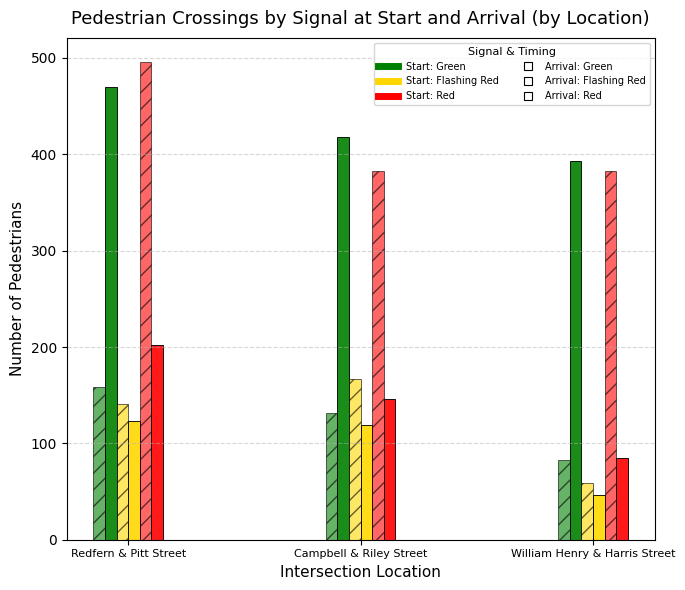

                        Location  Signal  Count SignalType
0        Campbell & Riley Street     0.0    131    Arrival
1        Campbell & Riley Street     1.0    167    Arrival
2        Campbell & Riley Street     2.0    383    Arrival
3          Redfern & Pitt Street     0.0    158    Arrival
4          Redfern & Pitt Street     1.0    141    Arrival
5          Redfern & Pitt Street     2.0    496    Arrival
6  William Henry & Harris Street     0.0     83    Arrival
7  William Henry & Harris Street     1.0     59    Arrival
8  William Henry & Harris Street     2.0    383    Arrival


In [225]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ---------------- CONFIG ----------------
HARD_FILE = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/REGRESSION_SINGLE_HARD_COMPLIANCE.csv"

# ---------------- LOAD DATA ----------------
df = pd.read_csv(HARD_FILE)
df["ComplianceType"] = "Hard"

# ---------------- MAP SESSIONS TO LOCATIONS ----------------
# Extract session prefix ("3", "4", "5") and map to site names
df["SessionGroup"] = df["Session"].astype(str).str[0]
location_map = {
    "3": "Redfern & Pitt Street",
    "4": "Campbell & Riley Street",
    "5": "William Henry & Harris Street"
}
df["Location"] = df["SessionGroup"].map(location_map)

# ---------------- AGGREGATE COUNTS ----------------
start_summary = (
    df.groupby(["Location", "signal_at_start"])
    .size()
    .reset_index(name="Count")
)
start_summary["SignalType"] = "Start"
start_summary.rename(columns={"signal_at_start": "Signal"}, inplace=True)

arrival_summary = (
    df.groupby(["Location", "signal_at_arrival"])
    .size()
    .reset_index(name="Count")
)
arrival_summary["SignalType"] = "Arrival"
arrival_summary.rename(columns={"signal_at_arrival": "Signal"}, inplace=True)

# Combine both summaries
summary = pd.concat([start_summary, arrival_summary], ignore_index=True)

# ---------------- SORTING & SETUP ----------------
locations = ["Redfern & Pitt Street", "Campbell & Riley Street", "William Henry & Harris Street"]
signals = [0, 1, 2]
signal_colors = {0: "green", 1: "gold", 2: "red"}
signal_types = ["Arrival", "Start"]

x = np.arange(len(locations))
width = 0.1
offset = width * 1

# ---------------- CREATE FIGURE ----------------
fig, ax = plt.subplots(figsize=(7, 6))

for i, sig in enumerate(signals):
    for j, sig_type in enumerate(signal_types):
        subset = summary[(summary["Signal"] == sig) & (summary["SignalType"] == sig_type)]
        subset = subset.set_index("Location").reindex(locations, fill_value=0)

        bar_positions = x + (i - 1) * offset + (j - 0.5) * (width / 2)

        ax.bar(
            bar_positions,
            subset["Count"],
            width=width / 2,
            color=signal_colors[sig],
            alpha=0.9 if sig_type == "Start" else 0.6,
            edgecolor="black",
            linewidth=0.7,
            hatch="//" if sig_type == "Arrival" else "",
            label=f"{sig_type}: {sig}"
        )

# ---------------- AXIS & LABELS ----------------
ax.set_xticks(x)
ax.set_xticklabels(locations, rotation=0, ha="center", fontsize=8)
ax.set_xlabel("Intersection Location", fontsize=11)
ax.set_ylabel("Number of Pedestrians", fontsize=11)
ax.set_title("Pedestrian Crossings by Signal at Start and Arrival (by Location)", fontsize=13, pad=10)
ax.grid(axis="y", linestyle="--", alpha=0.5)

# ---------------- LEGEND ----------------
handles = [
    plt.Line2D([0], [0], color="green", lw=5, label="Start: Green"),
    plt.Line2D([0], [0], color="gold", lw=5, label="Start: Flashing Red"),
    plt.Line2D([0], [0], color="red", lw=5, label="Start: Red"),
    plt.Line2D([0], [0], color="green", lw=5, label="Arrival: Green", linestyle="", marker='s', 
               markerfacecolor="green", markeredgecolor="black", markeredgewidth=0.8, fillstyle='none'),
    plt.Line2D([0], [0], color="gold", lw=5, label="Arrival: Flashing Red", linestyle="", marker='s', 
               markerfacecolor="gold", markeredgecolor="black", markeredgewidth=0.8, fillstyle='none'),
    plt.Line2D([0], [0], color="red", lw=5, label="Arrival: Red", linestyle="", marker='s', 
               markerfacecolor="red", markeredgecolor="black", markeredgewidth=0.8, fillstyle='none'),
]

ax.legend(
    handles=handles,
    title="Signal & Timing",
    ncol=2,
    frameon=True,
    fontsize=7,         # smaller font for legend labels
    title_fontsize=8,   # smaller font for legend title
    loc="upper right"
)
plt.tight_layout()
plt.show()

print(arrival_summary)


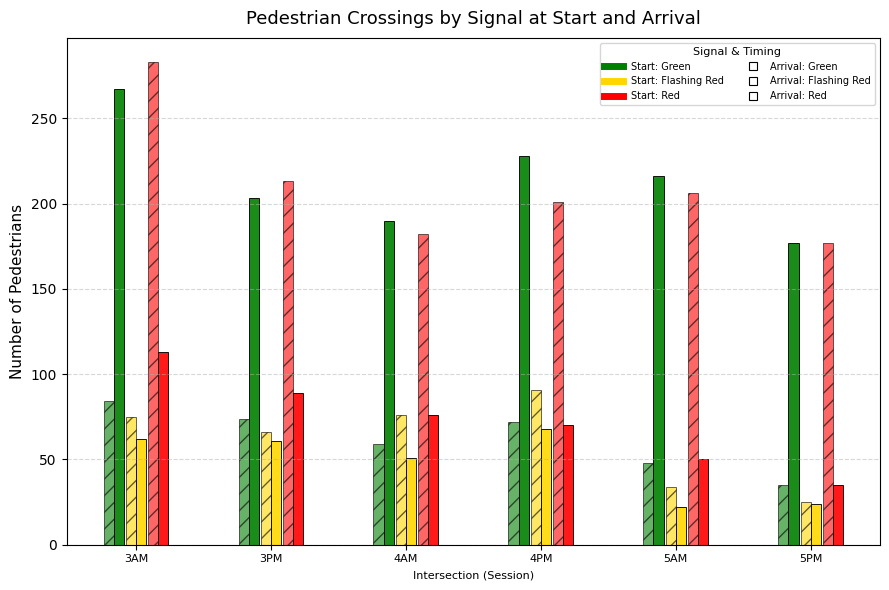

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ---------------- CONFIG ----------------
HARD_FILE = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/REGRESSION_SINGLE_HARD_COMPLIANCE.csv"

# ---------------- LOAD DATA ----------------
df = pd.read_csv(HARD_FILE)
df["ComplianceType"] = "Hard"

start_summary = (
    df.groupby(["Session", "signal_at_start"])
    .size()
    .reset_index(name="Count")
)
start_summary["SignalType"] = "Start"
start_summary.rename(columns={"signal_at_start": "Signal"}, inplace=True)

arrival_summary = (
    df.groupby(["Session", "signal_at_arrival"])
    .size()
    .reset_index(name="Count")
)
arrival_summary["SignalType"] = "Arrival"
arrival_summary.rename(columns={"signal_at_arrival": "Signal"}, inplace=True)

# Combine both summaries
summary = pd.concat([start_summary, arrival_summary], ignore_index=True)
# ---------------- MAP SESSION NAMES ----------------
session_map = {
    1: "RP(AM)",  # 3AM session
    2: "RP(PM)",  # 3PM session
    3: "CR(AM)",  # 4AM session
    4: "CR(PM)",  # 4PM session
    5: "WH(AM)",  # 5AM session
    6: "WH(PM)"   # 5PM session
}

summary["Session"] = summary["Session"].map(session_map).fillna(summary["Session"])

# ---------------- SORTING & SETUP ----------------
sessions = summary["Session"].unique()
signals = [0, 1, 2]
signal_colors = {0: "green", 1: "gold", 2: "red"}
signal_types = ["Arrival", "Start"]

x = np.arange(len(sessions))
width = 0.15        # slim bar width
offset = width * 1.1  # reduced distance between Arrival and Start bars

# ---------------- CREATE FIGURE ----------------
fig, ax = plt.subplots(figsize=(9, 6))

for i, sig in enumerate(signals):
    for j, sig_type in enumerate(signal_types):
        subset = summary[(summary["Signal"] == sig) & (summary["SignalType"] == sig_type)]
        subset = subset.set_index("Session").reindex(sessions, fill_value=0)

        # Positions: i for signal, j for type
        bar_positions = x + (i - 1) * offset + (j - 0.5) * (width / 2)

        ax.bar(
            bar_positions,
            subset["Count"],
            width=width / 2,
            color=signal_colors[sig],
            alpha=0.9 if sig_type == "Start" else 0.6,
            edgecolor="black",
            linewidth=0.7,
            hatch="//" if sig_type == "Arrival" else "",
            label=f"{sig_type}: {sig}"
        )

# ---------------- AXIS & LABELS ----------------
ax.set_xticks(x)
ax.set_xticklabels(sessions, rotation=0, ha="center", fontsize=8)
ax.set_xlabel("Intersection (Session)", fontsize=8)
ax.set_ylabel("Number of Pedestrians", fontsize=11)
ax.set_title("Pedestrian Crossings by Signal at Start and Arrival", fontsize=13, pad=10)
ax.grid(axis="y", linestyle="--", alpha=0.5)

# ---------------- LEGEND ----------------
# Custom legend for clarity
handles = [
    plt.Line2D([0], [0], color="green", lw=5, label="Start: Green"),
    plt.Line2D([0], [0], color="gold", lw=5, label="Start: Flashing Red"),
    plt.Line2D([0], [0], color="red", lw=5, label="Start: Red"),
    plt.Line2D([0], [0], color="green", lw=5, label="Arrival: Green", linestyle="", marker='s', 
               markerfacecolor="green", markeredgecolor="black", markeredgewidth=0.8, fillstyle='none'),
    plt.Line2D([0], [0], color="gold", lw=5, label="Arrival: Flashing Red", linestyle="", marker='s', 
               markerfacecolor="gold", markeredgecolor="black", markeredgewidth=0.8, fillstyle='none'),
    plt.Line2D([0], [0], color="red", lw=5, label="Arrival: Red", linestyle="", marker='s', 
               markerfacecolor="red", markeredgecolor="black", markeredgewidth=0.8, fillstyle='none'),
]

ax.legend(
    handles=handles,
    title="Signal & Timing",
    ncol=2,
    frameon=True,
    fontsize=7,         # smaller font for legend labels
    title_fontsize=8,   # smaller font for legend title
    loc="upper right"
)

plt.tight_layout()
plt.show()

print(arrival_summary)


In [215]:
import pandas as pd

# ---------------- LOAD DATA ----------------
FILE = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/REGRESSION_SINGLE_HARD_COMPLIANCE.csv"
df = pd.read_csv(FILE)

# ---------------- CONTINUOUS VARIABLES ----------------
continuous_cols = ['wait_time_s', 'time_to_next_vehicle_s', 'accepted_gap_s', 'leg_distance']

# ---------------- COMPUTE SUMMARY STATISTICS ----------------
summary_stats = df[continuous_cols].agg([
    'min', 
    lambda x: x.quantile(0.25),  # Q1
    'median', 
    'mean', 
    lambda x: x.quantile(0.75),  # Q3
    'max', 
    'std'
]).T

# Rename columns
summary_stats = summary_stats.rename(columns={
    'min': 'Min',
    '<lambda_0>': 'Q1',
    'median': 'Median',
    'mean': 'Mean',
    '<lambda_1>': 'Q3',
    'max': 'Max',
    'std': 'SD'
})

# Display neatly
print("\n===== Continuous Variable Summary =====")
print(summary_stats.round(2))

# ---------------- SHOW EXTREME RECORDS ----------------
min_value = df['wait_time_s'].min()
max_value = df['wait_time_s'].max()

# print(f"\nMinimum wait_time_s record:\n{df[df['wait_time_s'] == min_value]}")
print(f"\nMaximum wait_time_s record:\n{df[df['wait_time_s'] == max_value]}")



===== Continuous Variable Summary =====
                         Min  <lambda>  Median   Mean  <lambda>    Max     SD
wait_time_s             0.00       1.0    8.00  15.71      24.0  156.0  19.24
time_to_next_vehicle_s  0.07      10.0   15.00  18.97      25.0  106.0  14.18
accepted_gap_s          1.38      19.0   27.00  31.01      39.0  122.0  17.33
leg_distance            9.00       9.0   11.85  11.71      14.8   15.9   2.66

Maximum wait_time_s record:
      Accuator  Age  Gender  Using Phone  Group  Child Accompaniment  Pet Accompaniment  Running / Jogging  Cyclist  With Wheelchair  With Pram  two_stage_crossing prev_start_time  \
2000         1    3       1            0      0                    0                  0                  0        0                0          0                   0        00:58:17   

      prev_hard_compliance  hard_conformity  next_vehicle_type  time_to_next_vehicle_s  accepted_gap_s  wait_time_s Session  leg_distance  hard_compliance  signal_at_start  

In [208]:
import pandas as pd

# ---------------- LOAD DATA ----------------
FILE = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/REGRESSION_SINGLE_HARD_COMPLIANCE.csv"
df = pd.read_csv(FILE)

# Continuous variables
continuous_cols = ['wait_time_s', 'time_to_next_vehicle_s', 'accepted_gap_s', 'leg_distance']

# Map sessions to intersections
intersection_map = {'3': 'Redfern & Pitt Street',
                    '4': 'Campbell & Riley Street',
                    '5': 'William Henry & Harris Street'}
df['Intersection'] = df['Session'].astype(str).str[0].map(intersection_map)
print(df.shape)
# Compliance column
compliance_col = 'hard_conformity'  # 0 = Compliant, 1 = Non-Compliant

# Add a special 'Total' group for all intersections
intersections = list(df['Intersection'].dropna().unique()) + ['Total']

for inter in intersections:
    if inter == 'Total':
        subset_inter = df.copy()
    else:
        subset_inter = df[df['Intersection'] == inter]
    
    print(f"\n===== Intersection: {inter} =====")
    
    for comp_status, label in zip([0, 1], ['Compliant', 'Non-Compliant']):
        subset = subset_inter[subset_inter[compliance_col] == comp_status]
        
        if len(subset) == 0:
            print(f"\nNo {label} pedestrians at {inter}.")
            continue
        
        # Summary statistics
        summary_stats = subset[continuous_cols].agg(['min', 'median', 'mean', 'max', 'std']).T
        summary_stats = summary_stats.rename(columns={'min': 'Min', 'median': 'Median', 'mean': 'Mean',
                                                      'max': 'Max', 'std': 'SD'})
        print(f"\n--- Continuous Variable Summary ({label}) ---")
        print(summary_stats.round(2))
        
        # Rows with minimum wait_time_s
        min_value = subset['wait_time_s'].min()
        # print(f"\nMinimum wait_time_s record(s) ({label}):")
        # print(subset[subset['wait_time_s'] == min_value])



(2004, 27)

===== Intersection: Redfern & Pitt Street =====

--- Continuous Variable Summary (Compliant) ---
                         Min  Median   Mean    Max     SD
wait_time_s             0.00    5.00  11.46   85.0  14.79
time_to_next_vehicle_s  0.07   17.00  21.11  106.0  15.37
accepted_gap_s          1.38   28.24  33.06  122.0  19.50
leg_distance            9.00    9.00   9.06    9.2   0.09

--- Continuous Variable Summary (Non-Compliant) ---
                         Min  Median   Mean    Max     SD
wait_time_s             0.00    0.00   2.68   23.0   4.91
time_to_next_vehicle_s  0.64   19.29  22.27   71.0  13.57
accepted_gap_s          6.00   36.00  36.54  122.0  17.87
leg_distance            9.00    9.00   9.03    9.2   0.08

===== Intersection: Campbell & Riley Street =====

--- Continuous Variable Summary (Compliant) ---
                         Min  Median   Mean    Max     SD
wait_time_s             0.00     8.0  12.81   76.0  12.32
time_to_next_vehicle_s  0.61    16.0  17.7

In [1]:
import pandas as pd

# ---------------- LOAD DATA ----------------
FILE = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/REGRESSION_SINGLE_HARD_COMPLIANCE.csv"
df = pd.read_csv(FILE)

# Continuous variables
continuous_cols = ['wait_time_s', 'time_to_next_vehicle_s', 'accepted_gap_s', 'leg_distance']

# Map sessions to intersections
intersection_map = {'3': 'Redfern & Pitt Street',
                    '4': 'Campbell & Riley Street',
                    '5': 'William Henry & Harris Street'}
df['Intersection'] = df['Session'].astype(str).str[0].map(intersection_map)

# Intersections + Total group
intersections = list(df['Intersection'].dropna().unique()) + ['Total']

for inter in intersections:
    if inter == 'Total':
        subset_inter = df.copy()
    else:
        subset_inter = df[df['Intersection'] == inter]
    
    print(f"\n===== Intersection: {inter} (All Pedestrians) =====")
    
    # Overall summary for all pedestrians at this intersection
    overall_summary = subset_inter[continuous_cols].agg(['min', 'median', 'mean', 'max', 'std']).T
    overall_summary = overall_summary.rename(columns={'min': 'Min', 'median': 'Median', 'mean': 'Mean',
                                                      'max': 'Max', 'std': 'SD'})
    print(overall_summary.round(2))

    
# --- Summary for pedestrians running/jogging ---
    if "Running / Jogging" in subset_inter.columns:
        runners = subset_inter[subset_inter["Running / Jogging"] == 1]
        if not runners.empty:
            print(f"\n===== Intersection: {inter} (Running / Jogging = 1) =====")
            print(f"Sample size (n) = {len(runners)}")
            runner_summary = runners[continuous_cols].agg(['min', 'median', 'mean', 'max', 'std']).T
            runner_summary = runner_summary.rename(columns={'min': 'Min', 'median': 'Median', 'mean': 'Mean',
                                                            'max': 'Max', 'std': 'SD'})
            print(runner_summary.round(2))
        else:
            print(f"\n===== Intersection: {inter} (Running / Jogging = 1) =====")
            print("No pedestrians classified as running/jogging at this intersection.")
    else:
        print("\nColumn 'Running / Jogging' not found in dataset.")


===== Intersection: Redfern & Pitt Street (All Pedestrians) =====
                         Min  Median   Mean    Max     SD
wait_time_s             0.00     3.0  10.37   85.0  14.24
time_to_next_vehicle_s  0.07    18.0  21.26  106.0  15.15
accepted_gap_s          1.38    29.0  33.49  122.0  19.33
leg_distance            9.00     9.0   9.06    9.2   0.09

===== Intersection: Redfern & Pitt Street (Running / Jogging = 1) =====
Sample size (n) = 5
                          Min  Median   Mean   Max     SD
wait_time_s              0.00     0.0   3.40  17.0   7.60
time_to_next_vehicle_s  18.63    23.0  28.87  54.0  14.34
accepted_gap_s          27.56    34.0  37.78  57.0  11.52
leg_distance             9.00     9.0   9.08   9.2   0.11

===== Intersection: Campbell & Riley Street (All Pedestrians) =====
                         Min  Median   Mean    Max     SD
wait_time_s             0.00     7.0  12.16   76.0  12.30
time_to_next_vehicle_s  0.61    15.0  17.98   93.0  12.91
accepted_gap_s   

In [164]:
import pandas as pd

# ---------------- CONFIG ----------------
HARD_FILE = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/REGRESSION_SINGLE_HARD_COMPLIANCE.csv"

# ---------------- LOAD DATA ----------------
df = pd.read_csv(HARD_FILE)

# ---------------- MAP SESSIONS TO LOCATIONS ----------------
df["SessionGroup"] = df["Session"].astype(str).str[0]
location_map = {
    "3": "RP",   # Redfern & Pitt Street
    "4": "CR",   # Campbell & Riley Street
    "5": "WH"    # Harris Street
}
df["Location"] = df["SessionGroup"].map(location_map)

# ---------------- MAP SIGNAL CODES TO LABELS ----------------
signal_map = {0: "G", 1: "FR", 2: "R"}
df["signal_at_arrival"] = df["signal_at_arrival"].map(signal_map)
df["signal_at_start"] = df["signal_at_start"].map(signal_map)
# ---------------- CREATE SIGNAL COMBINATION ----------------
def categorize_combination(row):
    arrival = row["signal_at_arrival"]
    start = row["signal_at_start"]
    
    if arrival == "R" and start == "R":
        return "Arrive R → Start R"
    elif arrival == "G" and start == "FR":
        return "Arrive G → Start FR"
    elif arrival == "FR" and start == "FR":
        return "Arrive FR → Start FR"
    elif arrival == "FR" and start == "R":
        return "Arrive FR → Start R"
    else:
        return "Other"

df["Signal_Combo"] = df.apply(categorize_combination, axis=1)

# ---------------- SUMMARIZE BY LOCATION ----------------
summary_location = (
    df.groupby(["Location", "Signal_Combo"])
    .size()
    .reset_index(name="Count")
)

# Optional: add percentages within each location
summary_location["Percentage"] = summary_location.groupby("Location")["Count"].transform(lambda x: (x / x.sum() * 100).round(1))

# ---------------- DISPLAY ----------------
print(summary_location.sort_values(["Location", "Signal_Combo"]))


   Location          Signal_Combo  Count  Percentage
0        CR  Arrive FR → Start FR     87        12.7
1        CR   Arrive FR → Start R     27         4.0
2        CR   Arrive G → Start FR     25         3.7
3        CR    Arrive R → Start R    118        17.3
4        CR                 Other    426        62.4
5        RP  Arrive FR → Start FR    119        14.9
6        RP   Arrive FR → Start R      5         0.6
7        RP   Arrive G → Start FR      2         0.3
8        RP    Arrive R → Start R    195        24.5
9        RP                 Other    475        59.7
10       WH  Arrive FR → Start FR     29         5.5
11       WH   Arrive FR → Start R      9         1.7
12       WH   Arrive G → Start FR     14         2.7
13       WH    Arrive R → Start R     76        14.5
14       WH                 Other    397        75.6


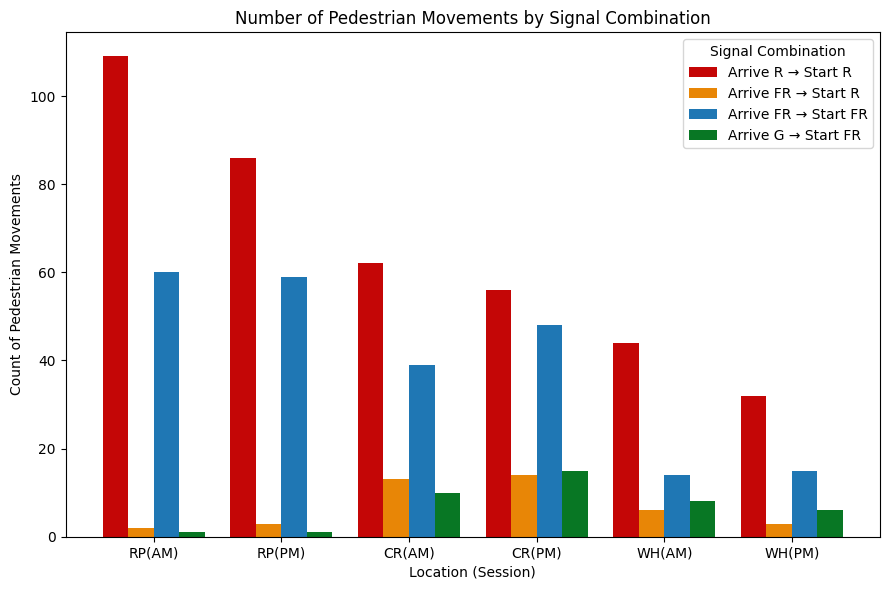

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ---------------- CONFIG ----------------
HARD_FILE = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/REGRESSION_SINGLE_HARD_COMPLIANCE.csv"

# ---------------- LOAD DATA ----------------
df = pd.read_csv(HARD_FILE)

# ---------------- MAP SESSIONS TO LOCATIONS ----------------
location_map = {
    "3AM": "RP(AM)",
    "3PM": "RP(PM)",
    "4AM": "CR(AM)",
    "4PM": "CR(PM)",
    "5AM": "WH(AM)",
    "5PM": "WH(PM)"
}
df["Location"] = df["Session"].map(location_map)

# ---------------- MAP SIGNAL CODES TO LABELS ----------------
signal_map = {0: "G", 1: "FR", 2: "R"}
df["signal_at_arrival"] = df["signal_at_arrival"].map(signal_map)
df["signal_at_start"] = df["signal_at_start"].map(signal_map)

# ---------------- CREATE SIGNAL COMBINATION ----------------
def categorize_combination(row):
    a, s = row["signal_at_arrival"], row["signal_at_start"]
    if a == "R" and s == "R":
        return "Arrive R → Start R"
    elif a == "FR" and s == "R":
        return "Arrive FR → Start R"
    elif a == "FR" and s == "FR":
        return "Arrive FR → Start FR"
    elif a == "G" and s == "FR":
        return "Arrive G → Start FR"
    else:
        return "Other"

df["Signal_Combo"] = df.apply(categorize_combination, axis=1)

# ---------------- SUMMARIZE BY SESSION ----------------
summary = (
    df[df["Signal_Combo"].isin([
        "Arrive R → Start R",
        "Arrive FR → Start R",
        "Arrive FR → Start FR",
        "Arrive G → Start FR"
    ])]
    .groupby(["Session", "Signal_Combo"])
    .size()
    .reset_index(name="Count")
)

# ---------------- SET ORDER ----------------
sessions_order = ["3AM", "3PM", "4AM", "4PM", "5AM", "5PM"]
locations_order = [location_map[s] for s in sessions_order]
signal_combos = ["Arrive R → Start R", "Arrive FR → Start R", "Arrive FR → Start FR", "Arrive G → Start FR"]

colors = ["#c40606", "#e88606",  "#1f77b4",  "#087724"]

# ---------------- PLOT ----------------
plt.figure(figsize=(9,6))
x = np.arange(len(sessions_order))
bar_width = 0.8 / len(signal_combos)

for i, combo in enumerate(signal_combos):
    counts = summary[summary['Signal_Combo']==combo].set_index('Session').reindex(sessions_order)['Count'].fillna(0)
    plt.bar(
        x + i*bar_width,
        counts,
        width=bar_width,
        color=colors[i],
        # edgecolor='black',
        label=combo
    )

# X-axis labels = locations
plt.xticks(x + bar_width*(len(signal_combos)-1)/2, locations_order)
plt.xlabel("Location (Session)")
plt.ylabel("Count of Pedestrian Movements")
plt.title("Number of Pedestrian Movements by Signal Combination")
plt.legend(title="Signal Combination")
plt.tight_layout()
plt.show()


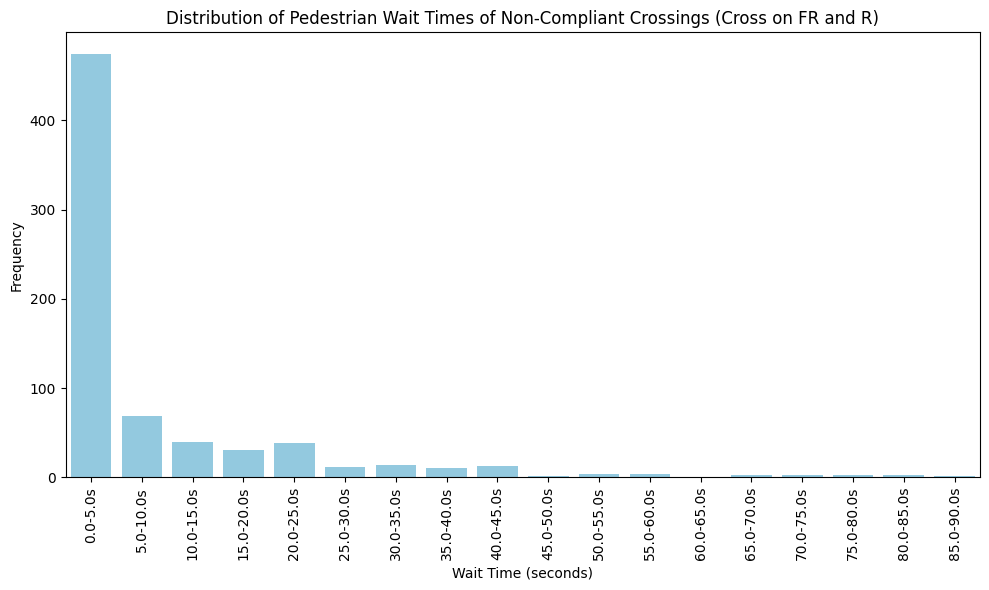

===== WAIT TIME SUMMARY (NON-COMPLIANT PEDESTRIANS(R and FR)) =====
Minimum wait time: 0.00 s
Median wait time:  3.00 s
Mean wait time:    8.43 s
Maximum wait time: 89.00 s
          Using Phone Count  Total Count  Percentage Using Phone
wait_bin                                                        
0-15s                    61          579                    10.5
15-40s                   19          109                    17.4
40s+                      9           33                    27.3
                  mean  median  min   max
Not Using Phone   7.64     2.0  0.0  85.0
Using Phone      14.03     5.0  0.0  89.0


/var/folders/1g/kfv0kct16s1gdd4k7rzps5tr0000gn/T/ipykernel_858/2090956943.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("wait_bin")
/var/folders/1g/kfv0kct16s1gdd4k7rzps5tr0000gn/T/ipykernel_858/2090956943.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df.groupby("wait_bin").size().reindex(labels, fill_value=0)


In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter


# ---------------- CONFIG ----------------
FILE = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/REGRESSION_SINGLE_HARD_COMPLIANCE.csv"

# ---------------- LOAD DATA ----------------
df = pd.read_csv(FILE)
df = df[df["hard_compliance"] == 1]

# ---------------- BIN WAIT TIMES ----------------
bins = np.arange(0, df["wait_time_s"].max() + 5, 5)
labels = [f"{i}-{i+5}s" for i in bins[:-1]]

df["wait_bin"] = pd.cut(df["wait_time_s"], bins=bins, labels=labels, include_lowest=True)

# ---------------- COUNT FREQUENCIES ----------------
wait_summary = (
    df["wait_bin"]
    .value_counts()
    .sort_index()
    .reset_index()
)

# Rename columns properly
wait_summary.columns = ["Wait Bin", "Frequency"]

# ---------------- PLOT ----------------
plt.figure(figsize=(10, 6))
sns.barplot(data=wait_summary, x="Wait Bin", y="Frequency", color="skyblue")

plt.title("Distribution of Pedestrian Wait Times of Non-Compliant Crossings (Cross on FR and R)")
plt.xlabel("Wait Time (seconds)")
plt.ylabel("Frequency")
plt.xticks(rotation=90)

# plt.yscale("log")
# plt.gca().yaxis.set_major_formatter(ScalarFormatter())
# plt.gca().yaxis.set_minor_formatter(ScalarFormatter())
# plt.gca().ticklabel_format(style="plain", axis="y")

plt.tight_layout()
plt.show()
# ---------------- PRINT SUMMARY STATS ----------------
print("===== WAIT TIME SUMMARY (NON-COMPLIANT PEDESTRIANS(R and FR)) =====")
print(f"Minimum wait time: {df['wait_time_s'].min():.2f} s")
print(f"Median wait time:  {df['wait_time_s'].median():.2f} s")
print(f"Mean wait time:    {df['wait_time_s'].mean():.2f} s")
print(f"Maximum wait time: {df['wait_time_s'].max():.2f} s")

# Define bins and labels
bins = [0, 15, 40, float('inf')]
labels = ["0-15s", "15-40s", "40s+"]

# Assign wait time bins
df["wait_bin"] = pd.cut(df["wait_time_s"], bins=bins, labels=labels, right=False)

# Count using phone per bin
using_phone_counts = (
    df[df["Using Phone"] == 1]
    .groupby("wait_bin")
    .size()
    .reindex(labels, fill_value=0)  # ensure all bins appear
)

# Total pedestrians per bin
total_counts = df.groupby("wait_bin").size().reindex(labels, fill_value=0)

# Percentage using phone per bin
percentage_using_phone = (using_phone_counts / total_counts * 100).round(1)

# Display results
summary = pd.DataFrame({
    "Using Phone Count": using_phone_counts,
    "Total Count": total_counts,
    "Percentage Using Phone": percentage_using_phone
})

print(summary)

import pandas as pd

# Group by Using Phone and calculate average wait time
avg_wait_by_phone = df.groupby("Using Phone")["wait_time_s"].agg(["mean", "median", "min", "max"]).round(2)

# Optional: rename index for clarity
avg_wait_by_phone.index = ["Not Using Phone", "Using Phone"]

print(avg_wait_by_phone)


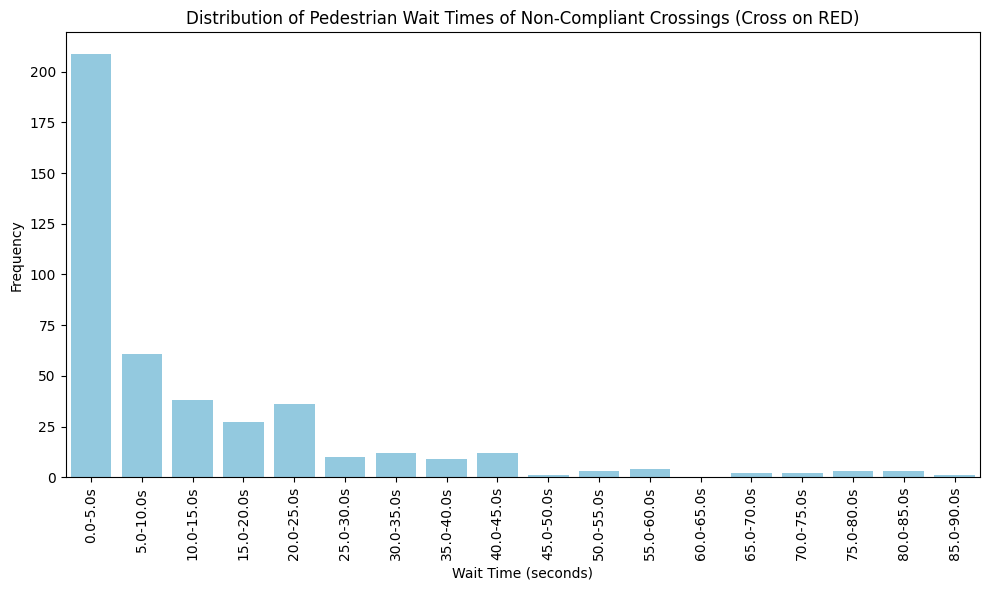

===== WAIT TIME SUMMARY (NON-COMPLIANT PEDESTRIANS (R)) =====
Minimum wait time: 0.00 s
Median wait time:  6.00 s
Mean wait time:    12.36 s
Maximum wait time: 89.00 s
          Using Phone Count  Total Count  Percentage Using Phone
wait_bin                                                        
0-15s                    32          303                    10.6
15-40s                   15           99                    15.2
40s+                      9           31                    29.0


/var/folders/1g/kfv0kct16s1gdd4k7rzps5tr0000gn/T/ipykernel_858/1586147829.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("wait_bin")
/var/folders/1g/kfv0kct16s1gdd4k7rzps5tr0000gn/T/ipykernel_858/1586147829.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df.groupby("wait_bin").size().reindex(labels, fill_value=0)


In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter


# ---------------- CONFIG ----------------
FILE = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/REGRESSION_SINGLE_SOFT_COMPLIANCE.csv"

# ---------------- LOAD DATA ----------------
df = pd.read_csv(FILE)
df = df[df["soft_compliance"] == 1]

# ---------------- BIN WAIT TIMES ----------------
bins = np.arange(0, df["wait_time_s"].max() + 5, 5)
labels = [f"{i}-{i+5}s" for i in bins[:-1]]

df["wait_bin"] = pd.cut(df["wait_time_s"], bins=bins, labels=labels, include_lowest=True)

# ---------------- COUNT FREQUENCIES ----------------
wait_summary = (
    df["wait_bin"]
    .value_counts()
    .sort_index()
    .reset_index()
)

# Rename columns properly
wait_summary.columns = ["Wait Bin", "Frequency"]

# ---------------- PLOT ----------------
plt.figure(figsize=(10, 6))
sns.barplot(data=wait_summary, x="Wait Bin", y="Frequency", color="skyblue")

plt.title("Distribution of Pedestrian Wait Times of Non-Compliant Crossings (Cross on RED)")
plt.xlabel("Wait Time (seconds)")
plt.ylabel("Frequency")
plt.xticks(rotation=90)

# plt.yscale("log")
# plt.gca().yaxis.set_major_formatter(ScalarFormatter())
# plt.gca().yaxis.set_minor_formatter(ScalarFormatter())
# plt.gca().ticklabel_format(style="plain", axis="y")

plt.tight_layout()
plt.show()

# ---------------- PRINT SUMMARY STATS ----------------
print("===== WAIT TIME SUMMARY (NON-COMPLIANT PEDESTRIANS (R)) =====")
print(f"Minimum wait time: {df['wait_time_s'].min():.2f} s")
print(f"Median wait time:  {df['wait_time_s'].median():.2f} s")
print(f"Mean wait time:    {df['wait_time_s'].mean():.2f} s")
print(f"Maximum wait time: {df['wait_time_s'].max():.2f} s")

# Define bins and labels
bins = [0, 15, 40, float('inf')]
labels = ["0-15s", "15-40s", "40s+"]

# Assign wait time bins
df["wait_bin"] = pd.cut(df["wait_time_s"], bins=bins, labels=labels, right=False)

# Count using phone per bin
using_phone_counts = (
    df[df["Using Phone"] == 1]
    .groupby("wait_bin")
    .size()
    .reindex(labels, fill_value=0)  # ensure all bins appear
)

# Total pedestrians per bin
total_counts = df.groupby("wait_bin").size().reindex(labels, fill_value=0)

# Percentage using phone per bin
percentage_using_phone = (using_phone_counts / total_counts * 100).round(1)

# Display results
summary = pd.DataFrame({
    "Using Phone Count": using_phone_counts,
    "Total Count": total_counts,
    "Percentage Using Phone": percentage_using_phone
})

print(summary)

In [58]:
# ============================================================
# Descriptive Statistics: Hard vs Soft Compliance, Single vs Two-Stage
# ============================================================

import pandas as pd
import numpy as np

# ---------------- CONFIG ----------------
HARD_FILE = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/REGRESSION_SINGLE_HARD_COMPLIANCE.csv"
SOFT_FILE = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/REGRESSION_SINGLE_SOFT_COMPLIANCE.csv"
OUTPUT_FOLDER = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/"

# ---------------- HELPER FUNCTION ----------------
def summarize_group(group, compliance_col):
    total = len(group)
    if total == 0:
        return pd.Series()

    total_compliant = (group[compliance_col] == 0).sum()
    total_noncompliant = (group[compliance_col] == 1).sum()
    using_phone = group["Using Phone"].sum()
    with_child = group["Child Accompaniment"].sum()
    actuated = group["Accuator"].sum()
    cyclists = group.get("Cyclist", pd.Series([0]*len(group))).sum()
    prams = group.get("With Pram", pd.Series([0]*len(group))).sum()
    wheelchairs = group.get("With Wheelchair", pd.Series([0]*len(group))).sum()
    male = group.get("Male", pd.Series([0]*len(group))).sum()
    female = group.get("Female", pd.Series([0]*len(group))).sum()

    # Age brackets
    age_cols = [c for c in group.columns if "Age" in c]
    age_counts = {c: group[c].sum() for c in age_cols}

    # Group sizes
    group_cols = [c for c in group.columns if "Group" in c]
    group_counts = {c: group[c].sum() for c in group_cols}

    summary = {
        "Total Pedestrians": total,
        "Comply": total_compliant,
        "Non-Comply": total_noncompliant,
        "Compliance Rate (%)": round(100 * total_compliant / total, 1) if total > 0 else None,
        "Using Phone": using_phone,
        "Using Phone Rate (%)": round(100 * using_phone / total, 1),
        "Child Accompaniment": with_child,
        "With Child Rate (%)": round(100 * with_child / total, 1),
        "Accuator Pressed": actuated,
        "Accuator Rate (%)": round(100 * actuated / total, 1),
        "Cyclists": cyclists,
        "Cyclist Rate (%)": round(100 * cyclists / total, 1),
        "With Pram": prams,
        "Pram Rate (%)": round(100 * prams / total, 1),
        "With Wheelchair": wheelchairs,
        "Wheelchair Rate (%)": round(100 * wheelchairs / total, 1),
        "Male (%)": round(100 * male / total, 1),
        "Female (%)": round(100 * female / total, 1)
    }

    for k, v in age_counts.items():
        summary[f"{k} (%)"] = round(100 * v / total, 1)
    for k, v in group_counts.items():
        summary[f"{k} (%)"] = round(100 * v / total, 1)

    return pd.Series(summary)

# ---------------- FUNCTION TO PROCESS FILE ----------------
def process_file(file_path, compliance_col, label):
    df = pd.read_csv(file_path)

    # Ensure binary columns exist
    binary_cols = ["two_stage_crossing", "Using Phone", "Child Accompaniment", "Accuator",
                   "Cyclist", "With Pram", "With Wheelchair"]
    for col in binary_cols:
        if col not in df.columns:
            df[col] = 0
        df[col] = df[col].fillna(0).astype(int)

    if compliance_col not in df.columns:
        df[compliance_col] = 0

    results = {}

    # Single-stage summary
    single_stage = df[df["two_stage_crossing"] == 0]
    ss_summary = single_stage.groupby("Session").apply(lambda g: summarize_group(g, compliance_col)).reset_index()
    ss_overall = summarize_group(single_stage, compliance_col).to_frame().T
    ss_overall.name = "All Sessions"
    ss_final = pd.concat([ss_summary, ss_overall], ignore_index=True)
    ss_csv = f"{OUTPUT_FOLDER}DESCRIPTIVE_{label.upper()}_SINGLE_STAGE.csv"
    ss_final.to_csv(ss_csv, index=False)
    results["single_stage"] = ss_final
    print(f"{label} single-stage summary saved to: {ss_csv}")

    # Two-stage summary
    two_stage = df[df["two_stage_crossing"] == 1]
    ts_summary = two_stage.groupby("Session").apply(lambda g: summarize_group(g, compliance_col)).reset_index()
    ts_overall = summarize_group(two_stage, compliance_col).to_frame().T
    ts_overall.name = "All Sessions"
    ts_final = pd.concat([ts_summary, ts_overall], ignore_index=True)
    ts_csv = f"{OUTPUT_FOLDER}DESCRIPTIVE_{label.upper()}_TWO_STAGE.csv"
    ts_final.to_csv(ts_csv, index=False)
    results["two_stage"] = ts_final
    print(f"{label} two-stage summary saved to: {ts_csv}")

    return results

# ---------------- PROCESS HARD AND SOFT FILES ----------------
print("Processing Hard Compliance...")
hard_results = process_file(HARD_FILE, "hard_conformity", "Hard")

print("Processing Soft Compliance...")
soft_results = process_file(SOFT_FILE, "soft_conformity", "Soft")

# ---------------- DISPLAY EXAMPLES ----------------
print("\n--- Hard Compliance, Single-Stage ---")
print(hard_results["single_stage"].to_string(index=False))
print("\n--- Hard Compliance, Two-Stage ---")
print(hard_results["two_stage"].to_string(index=False))
print("\n--- Soft Compliance, Single-Stage ---")
print(soft_results["single_stage"].to_string(index=False))
print("\n--- Soft Compliance, Two-Stage ---")
print(soft_results["two_stage"].to_string(index=False))


Processing Hard Compliance...
Hard single-stage summary saved to: /Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/DESCRIPTIVE_HARD_SINGLE_STAGE.csv
Hard two-stage summary saved to: /Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/DESCRIPTIVE_HARD_TWO_STAGE.csv
Processing Soft Compliance...
Soft single-stage summary saved to: /Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/DESCRIPTIVE_SOFT_SINGLE_STAGE.csv
Soft two-stage summary saved to: /Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/DESCRIPTIVE_SOFT_TWO_STAGE.csv

--- Hard Compliance, Single-Stage ---
Session  Total Pedestrians  Comply  Non-Comply  Compliance Rate (%)  Using Phone  Using Phone Rate (%)  Child Accompaniment  With Child Rate (%)  Accuator Pressed  Accuator Rate (%)  Cyclists  Cyclist Rate (%)

/var/folders/1g/kfv0kct16s1gdd4k7rzps5tr0000gn/T/ipykernel_38076/3103360655.py:85: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ss_summary = single_stage.groupby("Session").apply(lambda g: summarize_group(g, compliance_col)).reset_index()
/var/folders/1g/kfv0kct16s1gdd4k7rzps5tr0000gn/T/ipykernel_38076/3103360655.py:96: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ts_summary = two_stage.groupby("Session")

In [ ]:
# ============================================================
# Cross-tabulation Checks: Single-Stage vs Two-Stage Crossings
# ============================================================

import pandas as pd

# ---------------- CONFIG ----------------
FILE_PATH = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/REGRESSION_MASTER_SUBSET.csv"
OUTPUT_FOLDER = "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/"

# ---------------- LOAD AND CLEAN ----------------
df = pd.read_csv(FILE_PATH)

binary_cols = [
    "compliance", "two_stage_crossing", "Using Phone", "Child Accompaniment",
    "Accuator"
]
df[binary_cols] = df[binary_cols].fillna(0).astype(int)

# ---------------- SPLIT DATA ----------------
single_stage = df[df["two_stage_crossing"] == 0]
two_stage = df[df["two_stage_crossing"] == 1]

# ---------------- CROSS-TABS ----------------
# For single-stage crossings
ct_single_phone = pd.crosstab(single_stage["compliance"], single_stage["Using Phone"], margins=True)
ct_single_child = pd.crosstab(single_stage["compliance"], single_stage["Child Accompaniment"], margins=True)
ct_single_actuator = pd.crosstab(single_stage["compliance"], single_stage["Accuator"], margins=True)

# For two-stage crossings
ct_two_phone = pd.crosstab(two_stage["compliance"], two_stage["Using Phone"], margins=True)
ct_two_child = pd.crosstab(two_stage["compliance"], two_stage["Child Accompaniment"], margins=True)
ct_two_actuator = pd.crosstab(two_stage["compliance"], two_stage["Accuator"], margins=True)

# ---------------- DISPLAY ----------------
print("\n==============================")
print(" SINGLE-STAGE CROSSING CROSSTABS")
print("==============================")
print("\n Compliance vs Using Phone:")
print(ct_single_phone)
print("\n Compliance vs Child Accompaniment:")
print(ct_single_child)
print("\n Compliance vs Accuator Pressed:")
print(ct_single_actuator)

print("\n==============================")
print(" TWO-STAGE CROSSING CROSSTABS")
print("==============================")
print("\n Compliance vs Using Phone:")
print(ct_two_phone)
print("\n Compliance vs Child Accompaniment:")
print(ct_two_child)
print("\n Compliance vs Accuator Pressed:")
print(ct_two_actuator)

# ---------------- SAVE RESULTS ----------------
with pd.ExcelWriter(OUTPUT_FOLDER + "CROSSTABS_SINGLE_TWO_STAGE.xlsx") as writer:
    ct_single_phone.to_excel(writer, sheet_name="Single_Compliance_vs_Phone")
    ct_single_child.to_excel(writer, sheet_name="Single_Compliance_vs_Child")
    ct_single_actuator.to_excel(writer, sheet_name="Single_Compliance_vs_Accuator")
    ct_two_phone.to_excel(writer, sheet_name="Two_Compliance_vs_Phone")
    ct_two_child.to_excel(writer, sheet_name="Two_Compliance_vs_Child")
    ct_two_actuator.to_excel(writer, sheet_name="Two_Compliance_vs_Accuator")

print(f"\n Crosstab results saved to: {OUTPUT_FOLDER}CROSSTABS_SINGLE_TWO_STAGE.xlsx")



 SINGLE-STAGE CROSSING CROSSTABS

 Compliance vs Using Phone:
Using Phone     0    1   All
compliance                  
0             837  179  1016
1             650  104   754
All          1487  283  1770

 Compliance vs Child Accompaniment:
Child Accompaniment     0   1   All
compliance                         
0                     982  34  1016
1                     734  20   754
All                  1716  54  1770

 Compliance vs Accuator Pressed:
Accuator       0    1   All
compliance                 
0            533  483  1016
1            503  251   754
All         1036  734  1770

 TWO-STAGE CROSSING CROSSTABS

 Compliance vs Using Phone:
Using Phone    0   1  All
compliance               
0            205  55  260
1            165  43  208
All          370  98  468

 Compliance vs Child Accompaniment:
Child Accompaniment    0   1  All
compliance                       
0                    252   8  260
1                    206   2  208
All                  458  10  468

 Co

In [ ]:
#vehicle volume calcs
import pandas as pd
import glob
import re

# ====== CONFIG ======
DATA_FOLDER = '/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/VEHICLES/'
OUTPUT_CSV = '/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/VEH_VOLUME_SUMMARY.csv'

# ====== FUNCTION TO PROCESS ONE FILE ======
def process_file(file_path):
    filename = file_path.split('/')[-1].replace('.csv', '')
    
    # Extract session (e.g. 3AM, 3PM, etc.) from filename
    match = re.search(r'(\d[AP]M)', filename.upper())
    session = match.group(1) if match else 'UNKNOWN'
    site = re.sub(r'(\d[AP]M)', '', filename).strip('_').upper()

    df = pd.read_csv(file_path)
    
    # Convert all time columns to timedelta
    for dir in ['north', 'south', 'east', 'west']:
        df[f'{dir}.time'] = pd.to_timedelta(df[f'{dir}.time'].astype(str), errors='coerce')
    
    summary = {'site': site, 'session': session}

    # Calculate vehicle volume per hour for each approach
    for dir in ['north', 'south', 'east', 'west']:
        times = df[f'{dir}.time'].dropna()
        if len(times) > 1:
            total_time = (times.max() - times.min()).total_seconds()
            total_hours = total_time / 3600 if total_time > 0 else 1
            veh_per_hour = len(times) / total_hours
        else:
            veh_per_hour = len(times)
        summary[f'{dir}_veh_per_hr'] = round(veh_per_hour, 2)

    # Add total site volume
    summary['total_veh_per_hr'] = round(sum(summary[f'{d}_veh_per_hr'] for d in ['north', 'south', 'east', 'west']), 2)
    return summary


# ====== PROCESS ALL FILES IN FOLDER ======
all_files = glob.glob(f"{DATA_FOLDER}/*.csv")
summaries = [process_file(f) for f in all_files]

df_summary = pd.DataFrame(summaries)
df_summary = df_summary[['site', 'session', 'north_veh_per_hr', 'south_veh_per_hr',
                         'east_veh_per_hr', 'west_veh_per_hr', 'total_veh_per_hr']]
df_summary.sort_values(by=['site', 'session'], inplace=True)

# ====== SAVE OUTPUT ======
df_summary.to_csv(OUTPUT_CSV, index=False)

print("✅ Vehicle volumes per hour saved to:", OUTPUT_CSV)
print(df_summary)


✅ Vehicle volumes per hour saved to: /Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/VEH_VOLUME_SUMMARY.csv
   site session  north_veh_per_hr  south_veh_per_hr  east_veh_per_hr  \
1   VEH     3AM            294.69            322.15           631.40   
4   VEH     3PM            239.64            297.62           487.03   
0   VEH     4AM            309.08            309.08           635.00   
5   VEH     4PM            219.91            288.49           321.01   
2   VEH     5AM           1471.42            577.96          1385.35   
3   VEH     5PM           1210.95           1053.99           694.86   

   west_veh_per_hr  total_veh_per_hr  
1           573.69           1821.93  
4           364.85           1389.14  
0           359.31           1612.47  
5           249.32           1078.73  
2           976.25           4410.98  
3           571.66           3531.46  


In [139]:
import pandas as pd
import numpy as np
import os

# ---------------- CONFIG ----------------
DATA_FILES = [
    "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/3AM/3AM SIGNAL.csv",
    "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/3PM/3PM SIGNAL.csv",
    "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/4AM/4AM SIGNAL.csv",
    "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/4PM/4PM SIGNAL.csv",
    "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/5AM/5AM SIGNAL.csv",
    "/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/5PM/5PM SIGNAL.csv",
]

SESSIONS = ["3AM", "3PM", "4AM", "4PM", "5AM", "5PM"]

# ---------------- FUNCTION TO PROCESS ONE FILE ----------------
def summarize_session(file_path, session_name):
    df = pd.read_csv(file_path, sep=",")  # adjust sep if needed
    df.columns = df.columns.str.strip()

    time_cols = [c for c in df.columns if c.endswith(".time")]
    signal_cols = [c for c in df.columns if c.endswith(".signal")]

    all_stats = []

    for dir_time, dir_signal in zip(time_cols, signal_cols):
        temp = df[[dir_time, dir_signal]].copy()
        temp[dir_time] = pd.to_timedelta(temp[dir_time])
        temp['duration'] = temp[dir_time].shift(-1) - temp[dir_time]
        temp = temp[:-1]  # drop last NaT
        temp['duration_s'] = temp['duration'].dt.total_seconds()
        stats = temp.groupby(dir_signal)['duration_s'].agg(['min','median','mean','max'])
        all_stats.append(stats)

    # Combine directions by averaging stats
    combined = pd.concat(all_stats)
    session_stats = combined.groupby(combined.index).mean()  # average across directions

    # Flatten column names
    session_stats = session_stats.stack().to_dict()
    session_stats['Session'] = session_name
    return session_stats

# ---------------- PROCESS ALL SESSIONS ----------------
all_sessions = []
for file_path, session_name in zip(DATA_FILES, SESSIONS):
    if os.path.exists(file_path):
        all_sessions.append(summarize_session(file_path, session_name))
    else:
        print(f"Missing file: {file_path}")

# Combine all sessions into one DataFrame
summary_df = pd.DataFrame(all_sessions)

# Sort sessions
summary_df['Session'] = pd.Categorical(summary_df['Session'], categories=SESSIONS, ordered=True)
summary_df = summary_df.sort_values('Session').reset_index(drop=True)


# ---------------- ADD TOTAL ROW ----------------
total_row = summary_df.drop(columns='Session').mean().to_dict()
total_row['Session'] = 'Total'
summary_df = pd.concat([summary_df, pd.DataFrame([total_row])], ignore_index=True)

# ---------------- DISPLAY RESULTS ----------------
pd.set_option("display.max_columns", None)
print(summary_df.round(2))


   (FR, min)  (FR, median)  (FR, mean)  (FR, max)  (G, min)  (G, median)  (G, mean)  (G, max)  (R, min)  (R, median)  (R, mean)  (R, max) Session
0       6.00         10.00        9.94      10.00      5.00         8.00       7.95      8.00     12.50        33.00      38.11     88.00     3AM
1      10.00         10.00       10.00      10.00      6.00         6.00       6.00      6.00     16.49        33.50      33.27     69.50     3PM
2       6.03         15.00       14.19      15.00      3.66         6.00       5.88      6.00      5.93        28.01      26.86     63.55     4AM
3       2.90         14.00       13.47      14.00      1.42         6.00       5.90      6.00      2.63        25.49      27.23     68.08     4PM
4       8.00          8.00        8.00       8.00      4.00         4.00       4.00      4.00     21.40        87.70      86.93    142.10     5AM
5      16.00         16.00       16.00      16.00    -16.00         8.00       7.29      8.00     49.00        70.75      77